# NSCI 801 - Quantitative Neuroscience
## Correlation vs. Causality
Gunnar Blohm

### Outline

* What’s causality?
* How to achieve causality
    * Randomly controlled trials (RCT)
    * Regression and omitted variable bias
    * Instrumental variables (IV)
    * Granger causality
* Problem of unobserved variables in high-dimensional problems


### What's causality?
Wikipedia: "Causality is the influence by which one event, process, state or object (a cause) contributes to the production of another event, process, state or object (an effect), where the cause is partly responsible for the effect, and the effect is partly dependent on the cause"

Examples:
* caughing is a symptom of Covid. If you caugh, does it mean you have Covid?
* Covid leads to an immune response. If you have anti-bodies (without a vaccine), does it mean you had Covid?
* If wearing a mask reduces the risk of catching Covid, how do we know it's indeed an effective measure?

What is different in these examples?

### Association is NOT causality!
* we can use association to predict what will happen if we observe something
* but to understand **why** something happened or predict what would happen if we **intervened** we need causality!

**Causality** (probabilistic):  setting the value of the cause changes the probability distribution of the outcome

* Association: What is $P(y|x)$?
* Causality: What is $P(y|do(x))$?

**We cannot learn causality from passive observation! We must intervene...**

### The ladder of causality
<img style="float: center; width:800px;" src="stuff/ladderofcausality.png">
(from Pearl & Mackenzie, "The book of why")

### How to achieve causality - randomized controlled trials
(adapted from [Neuromatch Academy W3D3 Tutorial 1](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W3D3_NetworkCausality/student/W3D3_Tutorial1.ipynb#scrollTo=Gei4lKzwvoGi))

Let's take 2 neurons. What does it mean when we say neuron $A$ causes neuron $B$ to fire?

**Interventional definition of causality**: $(A \text{ causes } B) \Leftrightarrow ( \text{ If we force }A \text { to be different, then }B\text{ changes})$

**Mathematical (probabilistic) definition of causality**: $\delta_{A\to B} = \mathbb{E}[B | A=1] -  \mathbb{E}[B | A=0]$
* over many trials, the average causal effect $\delta_{A\to B}$ of neuron $A$ upon neuron $B$ is the average change in neuron $B$'s activity when we set $A=1$ versus when we set $A=0$
* The logic we just described is the logic of a randomized control trial (RCT). If you randomly give 100 people a drug and 100 people a placebo, the effect is the difference in outcomes.

Let's pretend we can perform a randomized controlled trial for two neurons. Our model will have neuron $A$ synapsing on Neuron $B$:
$$B = A + \epsilon$$
 where $A$ and $B$ represent the activities of the two neurons and $\epsilon$ is standard normal noise $\epsilon\sim\mathcal{N}(0,1)$.

Our goal is to perturb $A$ and confirm that $B$ changes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable

%config InlineBackend.figure_format = 'retina'
plt.style.use('dark_background')

In [2]:
def sigmoid(x):
    """
    Compute sigmoid nonlinearity element-wise on x

    Args:
        x (np.ndarray): the numpy data array we want to transform
    Returns
        (np.ndarray): x with sigmoid nonlinearity applied
    """
    return 1 / (1 + np.exp(-x))


def create_connectivity(n_neurons, random_state=42):
    """
    Generate our nxn causal connectivity matrix.

    Args:
        n_neurons (int): the number of neurons in our system.
        random_state (int): random seed for reproducibility

    Returns:
        A (np.ndarray): our 0.1 sparse connectivity matrix
    """
    np.random.seed(random_state)
    A_0 = np.random.choice([0, 1], size=(n_neurons, n_neurons), p=[0.9, 0.1])

    # set the timescale of the dynamical system to about 100 steps
    _, s_vals, _ = np.linalg.svd(A_0)
    A = A_0 / (1.01 * s_vals[0])

    # _, s_val_test, _ = np.linalg.svd(A)
    # assert s_val_test[0] < 1, "largest singular value >= 1"

    return A


def see_neurons(A, ax):
    """
    Visualizes the connectivity matrix.

    Args:
        A (np.ndarray): the connectivity matrix of shape (n_neurons, n_neurons)
        ax (plt.axis): the matplotlib axis to display on

    Returns:
        Nothing, but visualizes A.
    """
    A = A.T  # make up for opposite connectivity
    n = len(A)
    ax.set_aspect('equal')
    thetas = np.linspace(0, np.pi * 2, n, endpoint=False)
    x, y = np.cos(thetas), np.sin(thetas),
    ax.scatter(x, y, c='k', s=150)

    # Renormalize
    A = A / A.max()
    for i in range(n):
        for j in range(n):
            if A[i, j] > 0:
                ax.arrow(x[i], y[i], x[j] - x[i], y[j] - y[i], color='k', alpha=A[i,j],
                         head_width=.15, width = A[i, j] / 25, shape='right',
                         length_includes_head=True)
    ax.axis('off')


def get_perturbed_connectivity_all_neurons(perturbed_X):
    """
    Estimates the connectivity matrix of perturbations through stacked correlations.

    Args:
        perturbed_X (np.ndarray): the simulated dynamical system X of shape
                                  (n_neurons, timesteps)

    Returns:
        R (np.ndarray): the estimated connectivity matrix of shape
                        (n_neurons, n_neurons)
    """
    # select perturbations (P) and outcomes (Outs)
    # we perturb the system every over time step, hence the 2 in slice notation
    P = perturbed_X[:, ::2]
    Outs = perturbed_X[:, 1::2]

    # stack perturbations and outcomes into a 2n by (timesteps / 2) matrix
    S = np.concatenate([P, Outs], axis=0)

    # select the perturbation -> outcome block of correlation matrix (upper right)
    R = np.corrcoef(S)[:n_neurons, n_neurons:]

    return R


def simulate_neurons_perturb(A, timesteps):
    """
    Simulates a dynamical system for the specified number of neurons and timesteps,
    BUT every other timestep the activity is clamped to a random pattern of 1s and 0s

    Args:
        A (np.array): the true connectivity matrix
        timesteps (int): the number of timesteps to simulate our system.

    Returns:
        The results of the simulated system.
        - X has shape (n_neurons, timeteps)
    """
    n_neurons = len(A)
    X = np.zeros((n_neurons, timesteps))

    for t in range(timesteps - 1):

        if t % 2 == 0:
            X[:, t] = np.random.choice([0, 1], size=n_neurons)

        epsilon = np.random.multivariate_normal(np.zeros(n_neurons), np.eye(n_neurons))
        X[:, t + 1] = sigmoid(A.dot(X[:, t]) + epsilon)  # we are using helper function sigmoid

    return X


def plot_connectivity_matrix(A, ax=None):
  """Plot the (weighted) connectivity matrix A as a heatmap

    Args:
      A (ndarray): connectivity matrix (n_neurons by n_neurons)
      ax: axis on which to display connectivity matrix
  """
  if ax is None:
    ax = plt.gca()
  lim = np.abs(A).max()
  im = ax.imshow(A, vmin=-lim, vmax=lim, cmap="coolwarm")
  ax.tick_params(labelsize=10)
  ax.xaxis.label.set_size(15)
  ax.yaxis.label.set_size(15)
  cbar = ax.figure.colorbar(im, ax=ax, ticks=[0], shrink=.7)
  cbar.ax.set_ylabel("Connectivity Strength", rotation=90,
                     labelpad= 20,va="bottom")
  ax.set(xlabel="Connectivity from", ylabel="Connectivity to")


def plot_connectivity_graph_matrix(A):
  """Plot both connectivity graph and matrix side by side

    Args:
      A (ndarray): connectivity matrix (n_neurons by n_neurons)

  """
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))
  see_neurons(A,axs[0])  # we are invoking a helper function that visualizes the connectivity matrix
  plot_connectivity_matrix(A)

  fig.suptitle("Neuron Connectivity")
  plt.show()

def plot_neural_activity(X):
  """Plot first 10 timesteps of neural activity

  Args:
    X (ndarray): neural activity (n_neurons by timesteps)

  """
  f, ax = plt.subplots()
  im = ax.imshow(X[:, :10])
  divider = make_axes_locatable(ax)
  cax1 = divider.append_axes("right", size="5%", pad=0.15)
  plt.colorbar(im, cax=cax1)
  ax.set(xlabel='Timestep', ylabel='Neuron', title='Simulated Neural Activity')


def plot_true_vs_estimated_connectivity(estimated_connectivity, true_connectivity, selected_neuron=None):
  """Visualize true vs estimated connectivity matrices

  Args:
    estimated_connectivity (ndarray): estimated connectivity (n_neurons by n_neurons)
    true_connectivity (ndarray): ground-truth connectivity (n_neurons by n_neurons)
    selected_neuron (int or None): None if plotting all connectivity, otherwise connectivity
      from selected_neuron will be shown

  """

  fig, axs = plt.subplots(1, 2, figsize=(10, 5))

  if selected_neuron is not None:
    plot_connectivity_matrix(np.expand_dims(estimated_connectivity, axis=1), ax=axs[0])
    plot_connectivity_matrix(true_connectivity[:, [selected_neuron]], ax=axs[1])
    axs[0].set_xticks([0])
    axs[1].set_xticks([0])
    axs[0].set_xticklabels([selected_neuron])
    axs[1].set_xticklabels([selected_neuron])
  else:
    plot_connectivity_matrix(estimated_connectivity, ax=axs[0])
    plot_connectivity_matrix(true_connectivity, ax=axs[1])

  axs[1].set(title="True connectivity")
  axs[0].set(title="Estimated connectivity")

In [3]:
def neuron_B(activity_of_A):
  """Model activity of neuron B as neuron A activity + noise
  Args:
    activity_of_A (ndarray): An array of shape (T,) containing the neural activity of neuron A
  Returns:
    ndarray: activity of neuron B
  """
  noise = np.random.randn(activity_of_A.shape[0])
  return activity_of_A + noise

np.random.seed(12)

# Neuron A activity of zeros
A_0 = np.zeros(5000)

# Neuron A activity of ones
A_1 = np.ones(5000)

diff_in_means = neuron_B(A_1).mean() - neuron_B(A_0).mean()
print(diff_in_means)

0.9907195190159408


We could run all kinds of statistics on this result and would see that it's solid (consistently very close to 1).

Thus we can recover causality here *because* changing the firing of neuron $A$ did affect the firing of neuron $B$.

### Do randomized controlled trials work on networks of neurons?
Can we still estimate causal effects when the neurons are in big networks?

So let's create a system with N interconnected neurons that affect each other over time. Each neuron at time $t+1$ is a function of the activity of the other neurons from the previous time $t$. 

Neurons affect each other nonlinearly: each neuron's activity at time $t+1$ consists of a linearly weighted sum of all neural activities at time $t$, with added noise, passed through a nonlinearity:

$$
\vec{x}_{t+1} = \sigma(A\vec{x}_t + \epsilon_t), 
$$

- $\vec{x}_t$ is an $n$-dimensional vector representing our $n$-neuron system at timestep $t$
- $\sigma$ is a sigmoid nonlinearity
- $A$ is our $n \times n$ *causal ground truth connectivity matrix* (more on this later)
- $\epsilon_t$ is random noise: $\epsilon_t \sim N(\vec{0}, I_n)$
- $\vec{x}_0$ is initialized to $\vec{0}$

$A$ is a connectivity matrix, so the element $A_{ij}$ represents the causal effect of neuron $i$ on neuron $j$. In our system, neurons will receive connections from only 10% of the whole population on average.

So let's first have a look at the connectivity matrix...

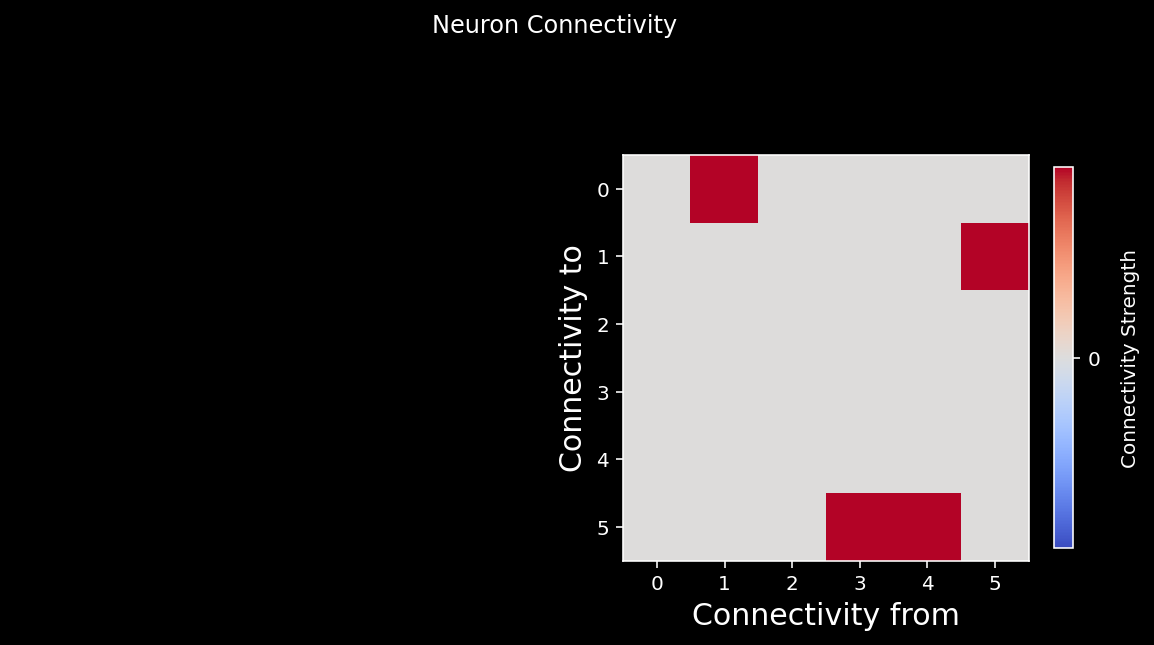

In [4]:
## Initializes the system
n_neurons = 6
A = create_connectivity(n_neurons) # we are invoking a helper function that generates our nxn causal connectivity matrix.

# Let's plot it!
plot_connectivity_graph_matrix(A)

Now we can simulate the dynamics of the system to see how each neuron's activity evolves over time.

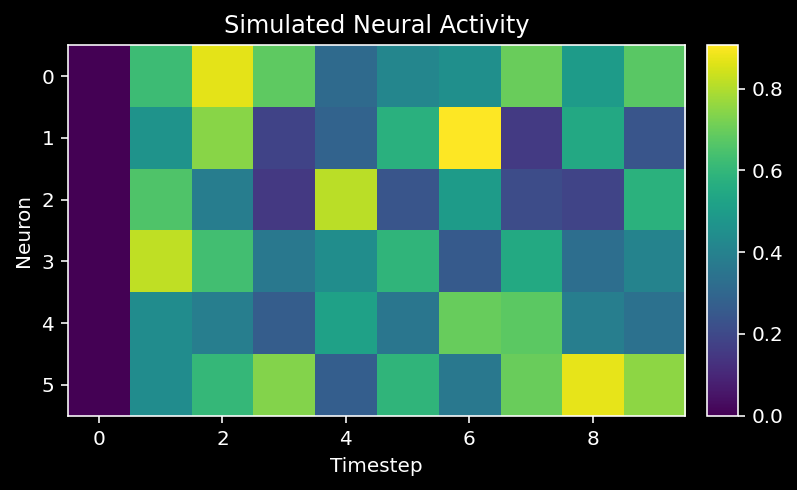

In [5]:
def simulate_neurons(A, timesteps, random_state=42):
    """Simulates a dynamical system for the specified number of neurons and timesteps.
    Args:
        A (np.array): the connectivity matrix
        timesteps (int): the number of timesteps to simulate our system.
        random_state (int): random seed for reproducibility
    Returns:
        - X has shape (n_neurons, timeteps). A schematic:
                   ___t____t+1___
       neuron  0  |   0    1     |
                  |   1    0     |
       neuron  i  |   0 -> 1     |
                  |   0    0     |
                  |___1____0_____|
    """
    np.random.seed(random_state)

    n_neurons = len(A)
    X = np.zeros((n_neurons, timesteps))

    for t in range(timesteps - 1):

        # Create noise vector
        epsilon = np.random.multivariate_normal(np.zeros(n_neurons), np.eye(n_neurons))

        # Update activity vector for next step
        X[:, t + 1] = sigmoid(A @ X[:, t] + epsilon)  # we are using helper function sigmoid

    return X


# Set simulation length
timesteps = 5000

# Uncomment below to test your function

# Simulate our dynamical system
X = simulate_neurons(A, timesteps)

plot_neural_activity(X)

### Recovering connectivity through perturbations
We will *intervene* in the neural activity by setting all neurons' activity randomly to either 0 or 1 on every second time step.

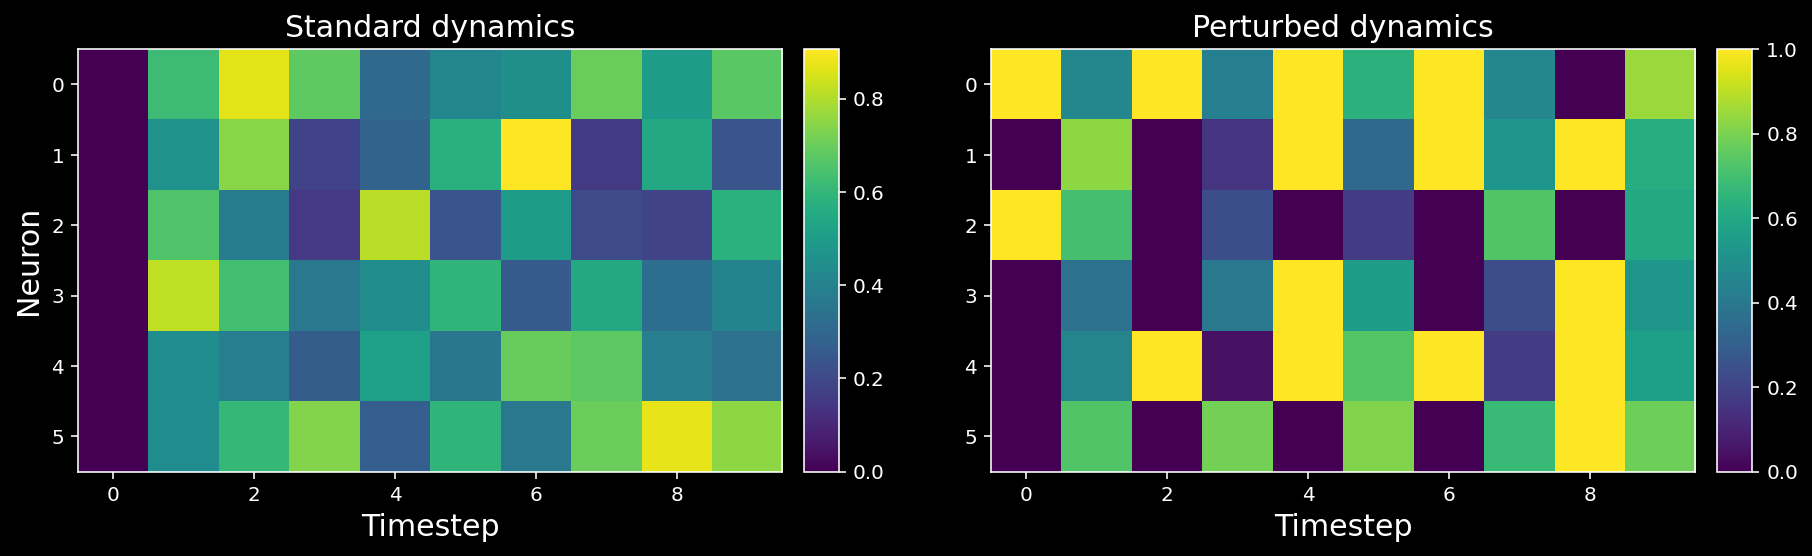

In [6]:
timesteps = 5000  # Simulate for 5000 timesteps.

# Simulate our dynamical system for the given amount of time
X_perturbed = simulate_neurons_perturb(A, timesteps)

# Plot our standard versus perturbed dynamics
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
im0 = axs[0].imshow(X[:, :10])
im1 = axs[1].imshow(X_perturbed[:, :10])

# Matplotlib boilerplate code
divider = make_axes_locatable(axs[0])
cax0 = divider.append_axes("right", size="5%", pad=0.15)
plt.colorbar(im0, cax=cax0)

divider = make_axes_locatable(axs[1])
cax1 = divider.append_axes("right", size="5%", pad=0.15)
plt.colorbar(im1, cax=cax1)

axs[0].set_ylabel("Neuron", fontsize=15)
axs[1].set_xlabel("Timestep", fontsize=15)
axs[0].set_xlabel("Timestep", fontsize=15);
axs[0].set_title("Standard dynamics", fontsize=15)
axs[1].set_title("Perturbed dynamics", fontsize=15);

From the above perturbed dynamics, we can write a function that recovers the causal effect of a given single neuron (`selected_neuron`) upon all other neurons in the system. Remember from above you're calculating:
$$
\color{grey}{\delta_{x^i\to x^j} \approx \frac1N \sum_i^N[x_{t+1}^j | x^i_t=1] -  \frac1N \sum_i^N[x_{t+1}^j | x^i_t=0] }
$$

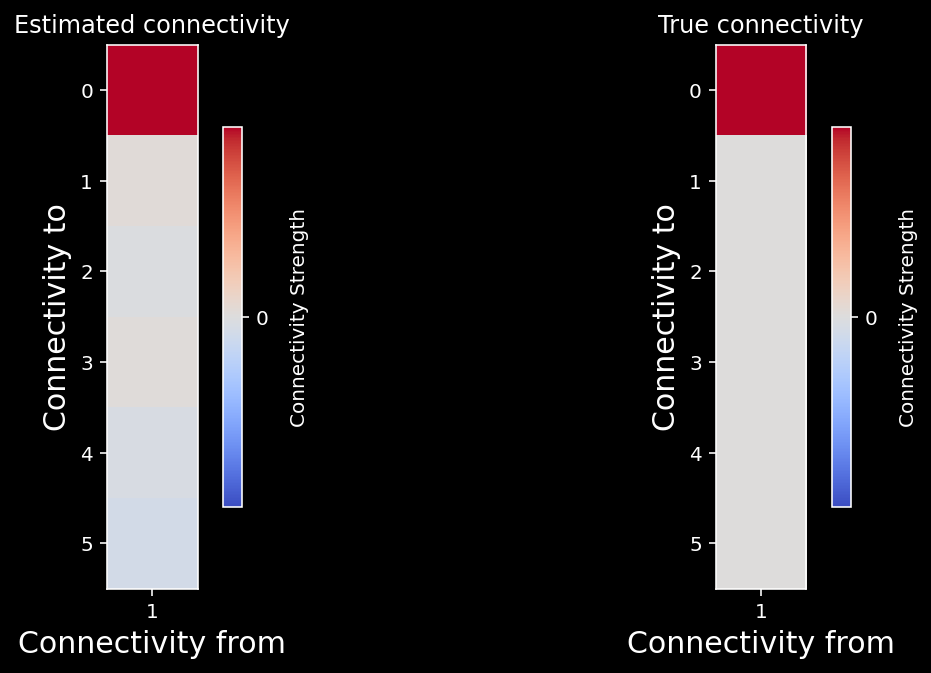

In [7]:
def get_perturbed_connectivity_from_single_neuron(perturbed_X, selected_neuron):
    """
    Computes the connectivity matrix from the selected neuron using differences in means.
    Args:
        perturbed_X (np.ndarray): the perturbed dynamical system matrix of shape (n_neurons, timesteps)
        selected_neuron (int): the index of the neuron we want to estimate connectivity for
    Returns:
        estimated_connectivity (np.ndarray): estimated connectivity for the selected neuron, of shape (n_neurons,)
    """
    # Extract the perturbations of neuron 1 (every other timestep)
    neuron_perturbations = perturbed_X[selected_neuron, ::2]

    # Extract the observed outcomes of all the neurons (every other timestep)
    all_neuron_output = perturbed_X[:, 1::2]

    # Initialize estimated connectivity matrix
    estimated_connectivity = np.zeros(n_neurons)

    # Loop over neurons
    for neuron_idx in range(n_neurons):

        # Get this output neurons (neuron_idx) activity
        this_neuron_output = all_neuron_output[neuron_idx, :]

        # Get timesteps where the selected neuron == 0 vs == 1
        one_idx = np.argwhere(neuron_perturbations == 1)
        zero_idx = np.argwhere(neuron_perturbations == 0)

        difference_in_means = np.mean(this_neuron_output[one_idx]) - np.mean(this_neuron_output[zero_idx])

        estimated_connectivity[neuron_idx] = difference_in_means

    return estimated_connectivity


# Initialize the system
n_neurons = 6
timesteps = 5000
selected_neuron = 1

# Simulate our perturbed dynamical system
perturbed_X = simulate_neurons_perturb(A, timesteps)

# Measure connectivity of neuron 1
estimated_connectivity = get_perturbed_connectivity_from_single_neuron(perturbed_X, selected_neuron)

plot_true_vs_estimated_connectivity(estimated_connectivity, A, selected_neuron)

We can quantify how close our estimated connectivity matrix is to our true connectivity matrix by correlating them. We should see almost perfect correlation between our estimates and the true connectivity - do we?

In [8]:
# Correlate true vs estimated connectivity matrix
np.corrcoef(A[:, selected_neuron], estimated_connectivity)[1, 0]

0.9960188025389387

Finally we can try to recover the whole connectivity matrix using the same strategy.

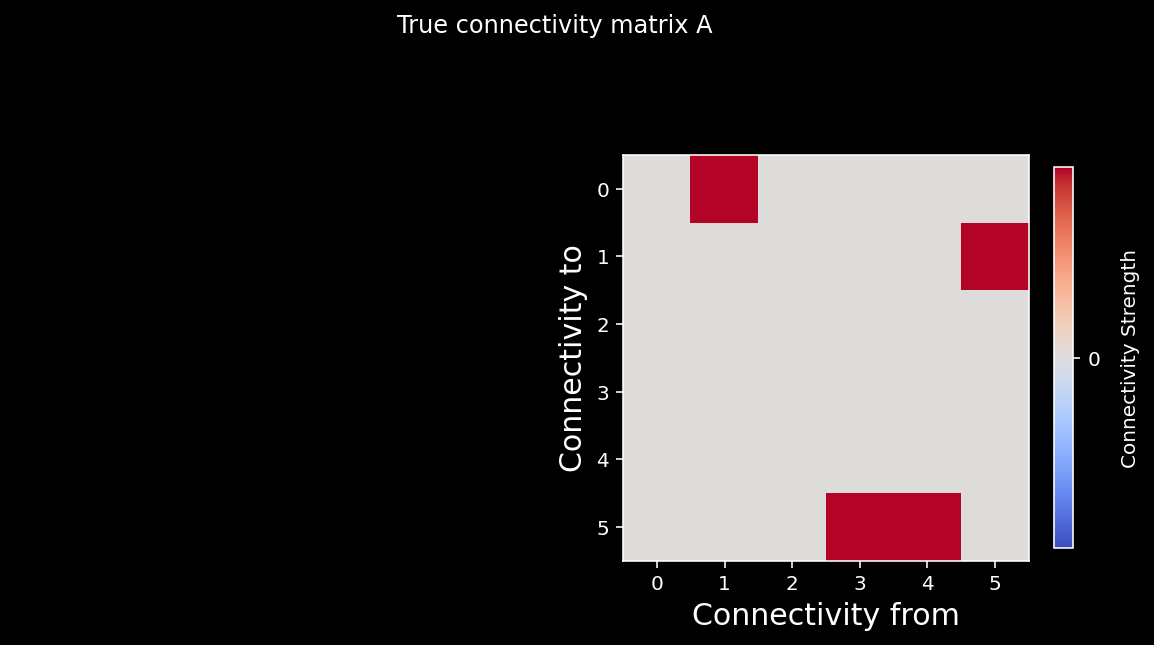

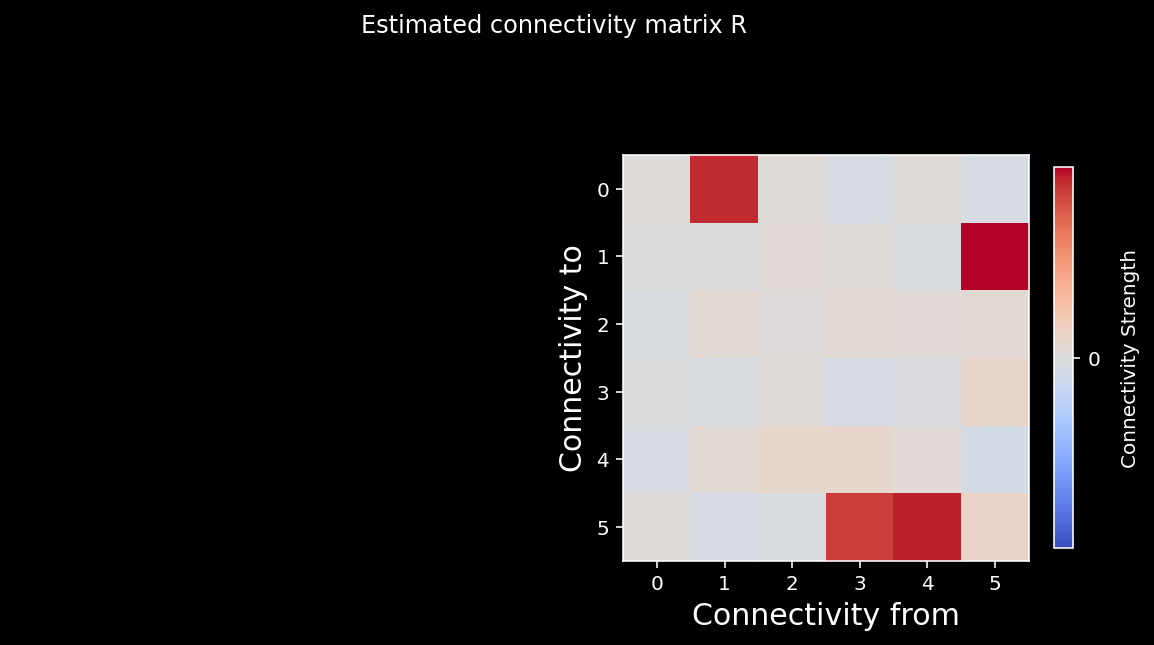

In [9]:
# Parameters
n_neurons = 6
timesteps = 5000

# Generate nxn causal connectivity matrix
A = create_connectivity(n_neurons)

# Simulate perturbed dynamical system
perturbed_X = simulate_neurons_perturb(A, timesteps)

# Get estimated connectivity matrix
R = get_perturbed_connectivity_all_neurons(perturbed_X)

# Let's visualize the true connectivity and estimated connectivity together
fig, axs = plt.subplots(1, 2, figsize=(10,5))
see_neurons(A, axs[0]) # we are invoking a helper function that visualizes the connectivity matrix
plot_connectivity_matrix(A, ax=axs[1])
plt.suptitle("True connectivity matrix A");
plt.show()
fig, axs = plt.subplots(1,2, figsize=(10,5))
see_neurons(R.T,axs[0]) # we are invoking a helper function that visualizes the connectivity matrix
plot_connectivity_matrix(R.T, ax=axs[1])
plt.suptitle("Estimated connectivity matrix R");

We can again calculate the correlation coefficient between the elements of the two matrices. As you can see from the cell below, we do a good job recovering the true causality of the system!

In [10]:
np.corrcoef(A.transpose().flatten(), R.flatten())[1, 0]

0.9875934043783577

### Correlation vs causation
In small systems, correlation can look like causation. Let's attempt to recover the true connectivity matrix (A) just by correlating the neural state at each timestep with the previous state: $C=\vec{x_t}{\vec{x_{t+1}}^T}$.

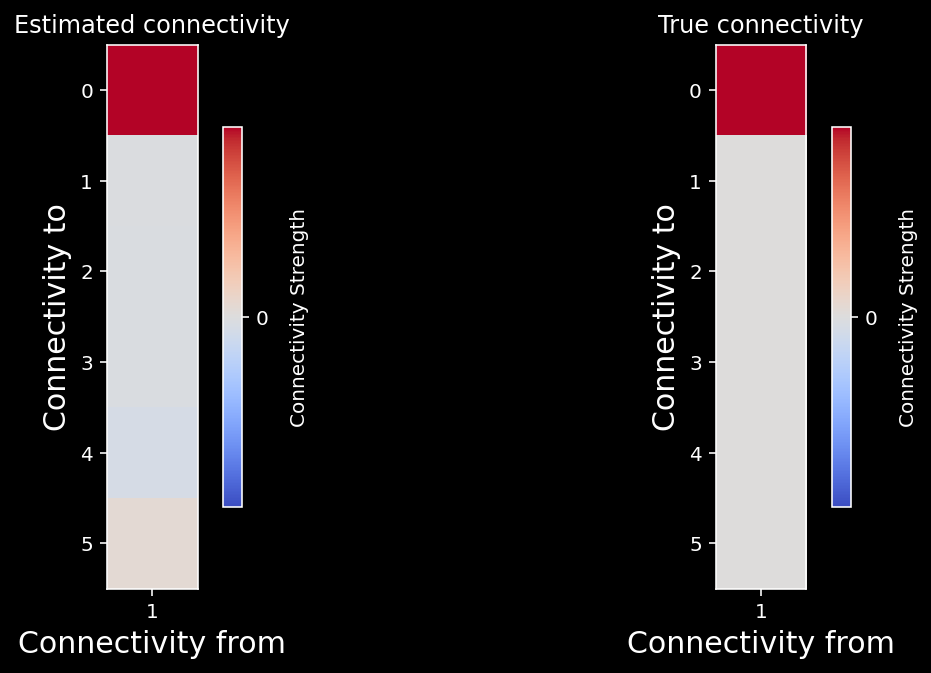

In [11]:
def compute_connectivity_from_single_neuron(X, selected_neuron):
    """
    Computes the connectivity matrix from a single neuron neurons using correlations
    Args:
        X (ndarray): the matrix of activities
        selected_neuron (int): the index of the selected neuron
    Returns:
        estimated_connectivity (ndarray): estimated connectivity for the selected neuron, of shape (n_neurons,)
    """

    # Extract the current activity of selected_neuron, t
    current_activity = X[selected_neuron, :-1]

    # Extract the observed outcomes of all the neurons
    next_activity = X[:, 1:]

    # Initialize estimated connectivity matrix
    estimated_connectivity = np.zeros(n_neurons)

    # Loop through all neurons
    for neuron_idx in range(n_neurons):

        # Get the activity of neuron_idx
        this_output_activity = next_activity[neuron_idx]

        # Compute correlation
        correlation = np.corrcoef(this_output_activity, current_activity)[0, 1]

        # Store this neuron's correlation
        estimated_connectivity[neuron_idx] = correlation

    return estimated_connectivity

# Simulate a 6 neuron system for 5000 timesteps again.
n_neurons = 6
timesteps = 5000
selected_neuron = 1

# Invoke a helper function that generates our nxn causal connectivity matrix
A = create_connectivity(n_neurons)

# Invoke a helper function that simulates the neural activity
X = simulate_neurons(A, timesteps)

# Uncomment below to test your function
estimated_connectivity = compute_connectivity_from_single_neuron(X, selected_neuron)

plot_true_vs_estimated_connectivity(estimated_connectivity, A, selected_neuron)

Well, that worked! Does if work for the whole network?

In [12]:
def get_sys_corr(n_neurons, timesteps, random_state=42, neuron_idx=None):
    """
    A wrapper function for our correlation calculations between A and R.

    Args:
        n_neurons (int): the number of neurons in our system.
        timesteps (int): the number of timesteps to simulate our system.
        random_state (int): seed for reproducibility
        neuron_idx (int): optionally provide a neuron idx to slice out

    Returns:
        A single float correlation value representing the similarity between A and R
    """

    A = create_connectivity(n_neurons, random_state)
    X = simulate_neurons(A, timesteps)

    R = correlation_for_all_neurons(X)

    return np.corrcoef(A.flatten(), R.flatten())[0, 1]


def correlation_for_all_neurons(X):
  """Computes the connectivity matrix for the all neurons using correlations

    Args:
        X: the matrix of activities

    Returns:
        estimated_connectivity (np.ndarray): estimated connectivity for the selected neuron, of shape (n_neurons,)
  """
  n_neurons = len(X)
  S = np.concatenate([X[:, 1:], X[:, :-1]], axis=0)
  R = np.corrcoef(S)[:n_neurons, n_neurons:]
  return R


def plot_estimation_quality_vs_n_neurons(number_of_neurons):
    """
    A wrapper function that calculates correlation between true and estimated connectivity
    matrices for each number of neurons and plots

    Args:
      number_of_neurons (list): list of different number of neurons for modeling system
      corr_func (function): Function for computing correlation
    """
    corr_data = np.zeros((n_trials, len(number_of_neurons)))
    for trial in range(n_trials):
      print("simulating trial {} of {}".format(trial + 1, n_trials))
      for j, size in enumerate(number_of_neurons):
          corr = get_sys_corr(size, timesteps, trial)
          corr_data[trial, j] = corr

    corr_mean = corr_data.mean(axis=0)
    corr_std = corr_data.std(axis=0)

    plt.plot(number_of_neurons, corr_mean)
    plt.fill_between(number_of_neurons,
                     corr_mean - corr_std,
                     corr_mean + corr_std,
                     alpha=.2)
    plt.xlabel("Number of neurons")
    plt.ylabel("Correlation")
    plt.title("Similarity between A and R as a function of network size")
    plt.show()


def plot_connectivity_matrix(A, ax=None):
  """Plot the (weighted) connectivity matrix A as a heatmap

    Args:
      A (ndarray): connectivity matrix (n_neurons by n_neurons)
      ax: axis on which to display connectivity matrix
  """
  if ax is None:
    ax = plt.gca()
  lim = np.abs(A).max()
  im = ax.imshow(A, vmin=-lim, vmax=lim, cmap="coolwarm")
  ax.tick_params(labelsize=10)
  ax.xaxis.label.set_size(15)
  ax.yaxis.label.set_size(15)
  cbar = ax.figure.colorbar(im, ax=ax, ticks=[0], shrink=.7)
  cbar.ax.set_ylabel("Connectivity Strength", rotation=90,
                     labelpad= 20, va="bottom")
  ax.set(xlabel="Connectivity from", ylabel="Connectivity to")


def plot_true_vs_estimated_connectivity(estimated_connectivity, true_connectivity, selected_neuron=None):
  """Visualize true vs estimated connectivity matrices

  Args:
    estimated_connectivity (ndarray): estimated connectivity (n_neurons by n_neurons)
    true_connectivity (ndarray): ground-truth connectivity (n_neurons by n_neurons)
    selected_neuron (int or None): None if plotting all connectivity, otherwise connectivity
      from selected_neuron will be shown

  """
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))

  if selected_neuron is not None:
    plot_connectivity_matrix(np.expand_dims(estimated_connectivity, axis=1), ax=axs[0])
    plot_connectivity_matrix(true_connectivity[:, [selected_neuron]], ax=axs[1])
    axs[0].set_xticks([0])
    axs[1].set_xticks([0])
    axs[0].set_xticklabels([selected_neuron])
    axs[1].set_xticklabels([selected_neuron])
  else:
    plot_connectivity_matrix(estimated_connectivity, ax=axs[0])
    plot_connectivity_matrix(true_connectivity, ax=axs[1])

  axs[1].set(title="True connectivity")
  axs[0].set(title="Estimated connectivity")

Correlation matrix of A and R: 0.9596667994046594


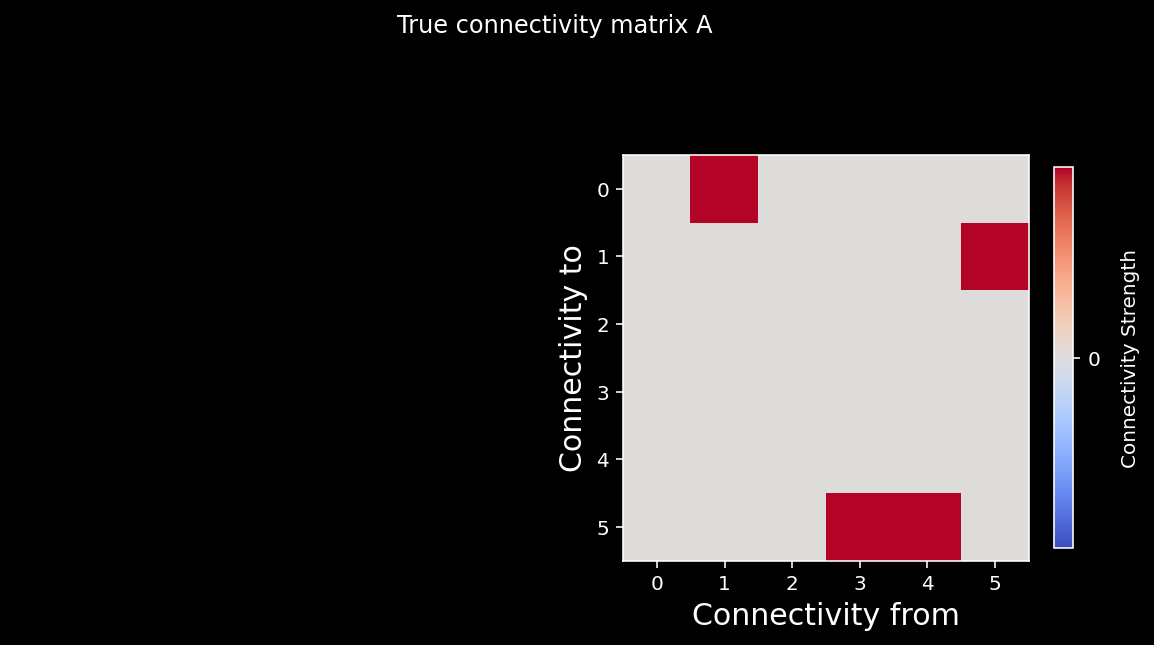

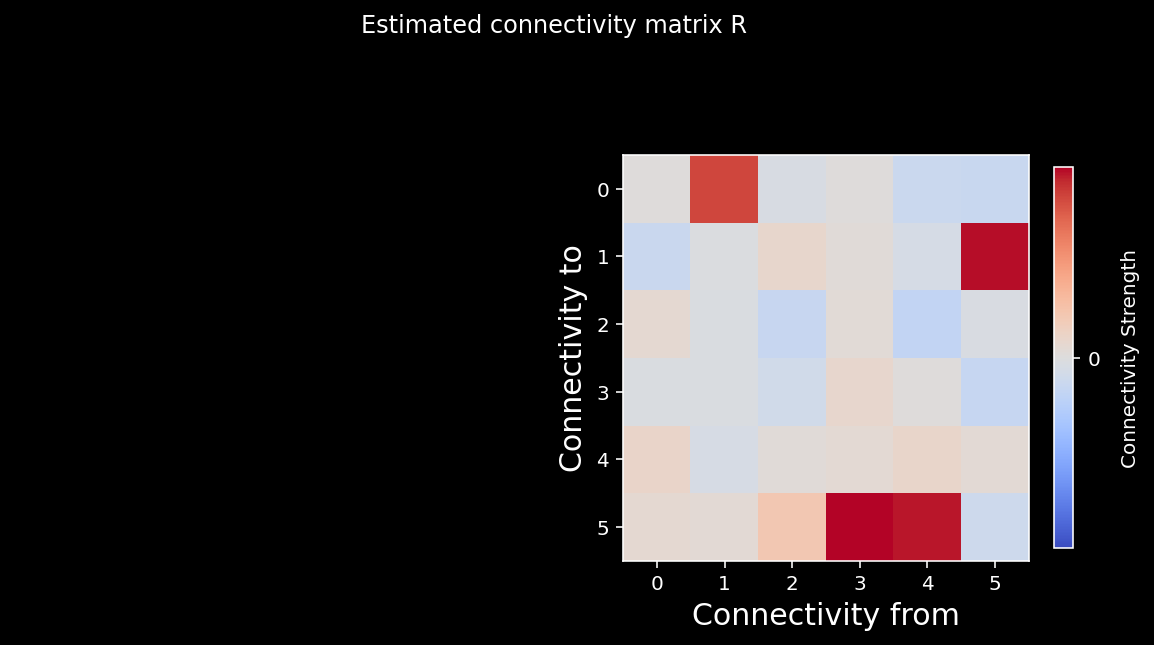

In [13]:
R = correlation_for_all_neurons(X)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
see_neurons(A, axs[0])
plot_connectivity_matrix(A, ax=axs[1])
plt.suptitle("True connectivity matrix A")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
see_neurons(R, axs[0])
plot_connectivity_matrix(R, ax=axs[1])
plt.suptitle("Estimated connectivity matrix R");

print("Correlation matrix of A and R:", np.corrcoef(A.flatten(), R.flatten())[0, 1])

YES! So what is all the fuss about "correlation is NOT causation"?

### Failure of correlation in complex systems
Let's jump to a much bigger system. Instead of 6 neurons, we will now use 100 neurons. How does the estimation quality of the connectivity matrix change?

Correlation matrix of A and R: 0.36293298241778177


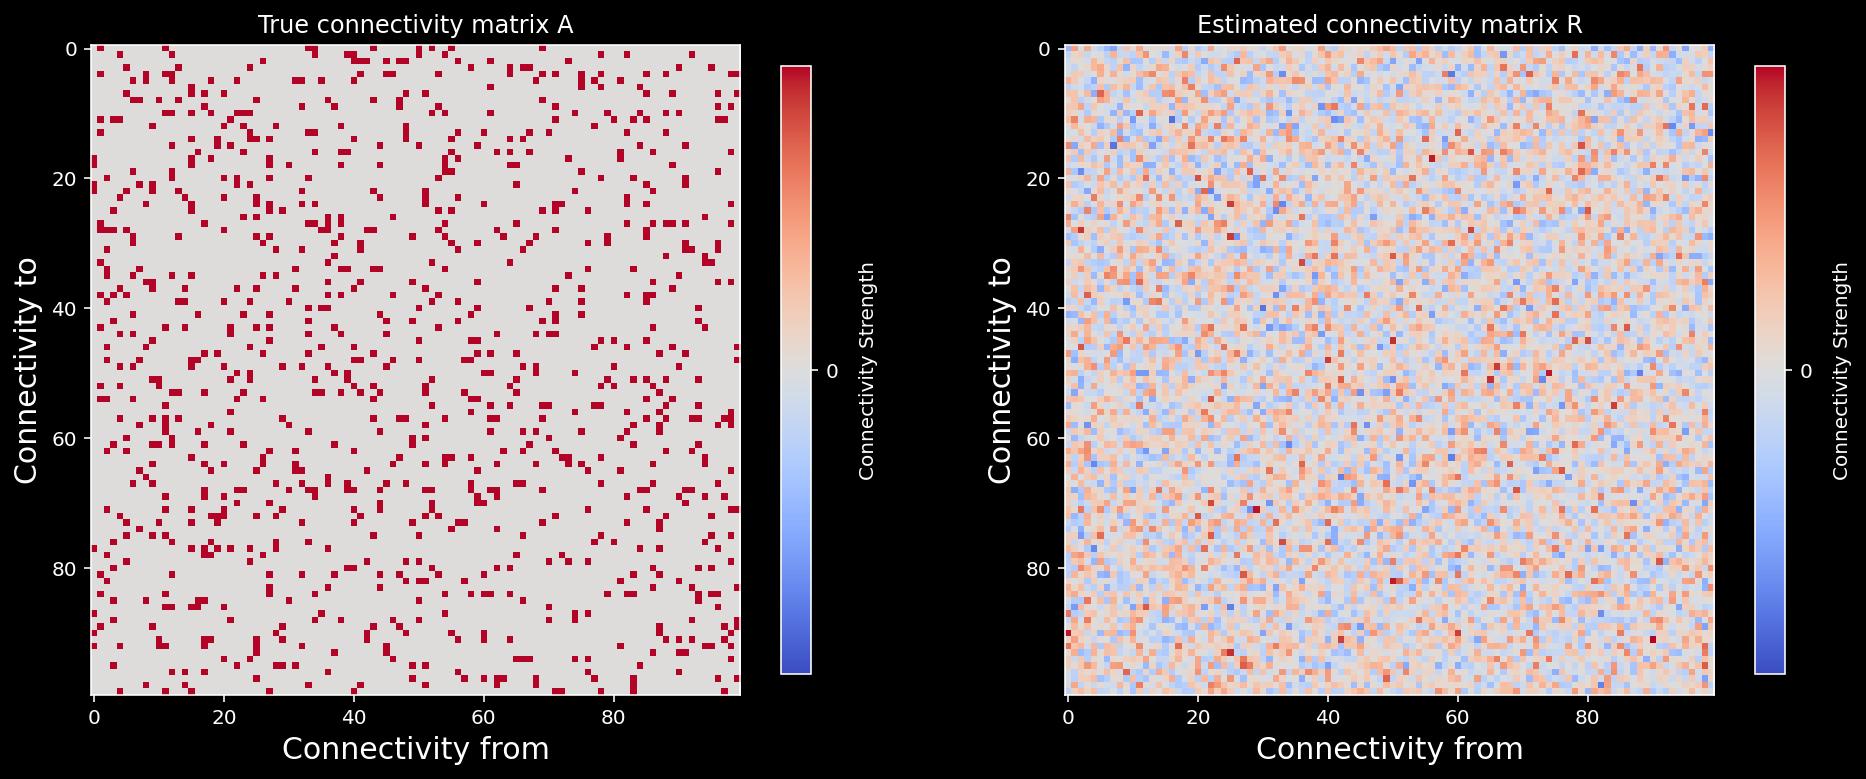

In [14]:
# Simulate a 100 neuron system for 5000 timesteps.
n_neurons = 100
timesteps = 5000
random_state = 42 

A = create_connectivity(n_neurons, random_state)
X = simulate_neurons(A, timesteps)
R = correlation_for_all_neurons(X)

print("Correlation matrix of A and R:", np.corrcoef(A.flatten(), R.flatten())[0, 1])

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
plot_connectivity_matrix(A, ax=axs[0])
axs[0].set_title("True connectivity matrix A")
plot_connectivity_matrix(R, ax=axs[1])
axs[1].set_title("Estimated connectivity matrix R");

Now **this** is why correlation measures cannot reliably identify causal interactions with limited data even when we observe the whole system!

We can plot how this method breaks down as a function of network size...

simulating trial 1 of 5
simulating trial 2 of 5
simulating trial 3 of 5


C:\Users\Gunnar\AppData\Local\Temp/ipykernel_19712/2244436019.py:29: RuntimeWarning: invalid value encountered in true_divide
  A = A_0 / (1.01 * s_vals[0])


simulating trial 4 of 5
simulating trial 5 of 5


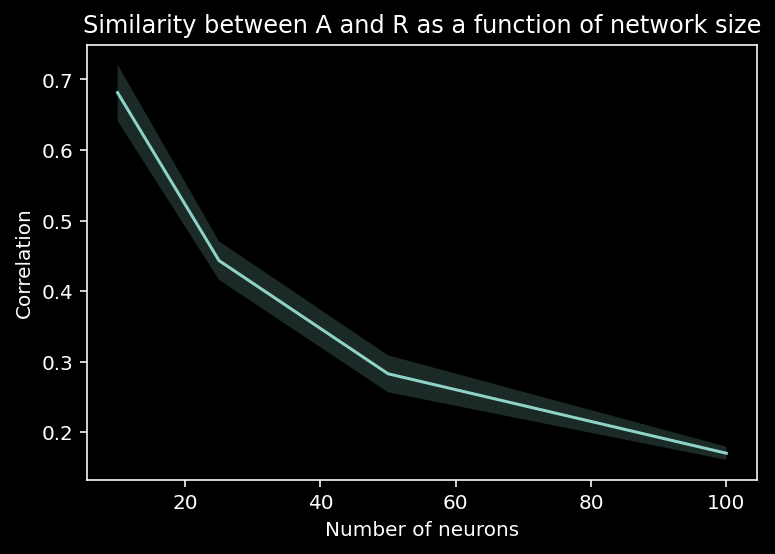

In [15]:
n_trials = 5
timesteps = 1000  # shorter timesteps for faster running time
number_of_neurons = [5, 10, 25, 50, 100]
plot_estimation_quality_vs_n_neurons(number_of_neurons)

And we can also look at how the sparsity of $A$ affects the estimation of connectivity...

In [16]:
def create_connectivity(n_neurons, random_state=42, p=0.9):
    """
    Generate our nxn causal connectivity matrix.

    Args:
        n_neurons (int): the number of neurons in our system.
        random_state (int): random seed for reproducibility

    Returns:
        A (np.ndarray): our 0.1 sparse connectivity matrix
    """
    np.random.seed(random_state)
    A_0 = np.random.choice([0, 1], size=(n_neurons, n_neurons), p=[p, 1 - p])

    # set the timescale of the dynamical system to about 100 steps
    _, s_vals, _ = np.linalg.svd(A_0)
    A = A_0 / (1.01 * s_vals[0])

    # _, s_val_test, _ = np.linalg.svd(A)
    # assert s_val_test[0] < 1, "largest singular value >= 1"

    return A

In [17]:
import ipywidgets as widgets       # interactive display

@widgets.interact(sparsity=(0.01, 0.99, .01))
def plot_corrs(sparsity=0.9):
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  timesteps = 2000
  random_state = 42
  n_neurons = 25
  A = create_connectivity(n_neurons, random_state, sparsity)
  X = simulate_neurons(A, timesteps)
  R = correlation_for_all_neurons(X)
  corr=np.corrcoef(A.flatten(), R.flatten())[0, 1]
  plot_connectivity_matrix(A, ax=axs[0])
  plot_connectivity_matrix(R, ax=axs[1])
  axs[0].set_title("True connectivity")
  axs[1].set_title("Estimated connectivity")
  axs[2].text(0, 0.5, "Correlation : {:.2f}".format(corr), size=15)
  axs[2].axis('off')

interactive(children=(FloatSlider(value=0.9, description='sparsity', max=0.99, min=0.01, step=0.01), Output())…

### Using regression to get at causality?
Simple correlation failed. But what about using some common advanced (but controversial) methods that estimate causality from observational data? 
* fitting a function to our data directly, instead of trying to use perturbations or correlations
* estimate causal connectivity when there are no perturbations

This only works of course if there are no *confounders*. **A confound is any variable that affects both the outcome and your original covariate.**

**Controlling for a confound**: 
Confonds can be controlled for by adding them as covariates in a regression. But for your coefficients to be causal effects, you need three things:
 
1.   **All** confounds are included as covariates
2.   Your regression assumes the same mathematical form of how covariates relate to outcomes (linear, GLM, etc.)
3.   No covariates are caused *by* both the treatment (original variable) and the outcome. These are [colliders](https://en.wikipedia.org/wiki/Collider_(statistics)); we won't introduce it today (but Google it on your own time! Colliders are very counterintuitive.)

In the real world it is very hard to guarantee these conditions are met. In the brain it's even harder (as we can't measure all neurons).

### Fitting a GLM
Recall that in our system each neuron effects every other via:

$$
\vec{x}_{t+1} = \sigma(A\vec{x}_t + \epsilon_t), 
$$

where $\sigma$ is our sigmoid nonlinearity from before: $\color{grey}{\sigma(x) = \frac{1}{1 + e^{-x}}}$

Our system is a closed system, too, so there are no omitted variables. The regression coefficients should be the causal effect. Are they?

We will use a regression approach to estimate the causal influence of all neurons to neuron #1. Specifically, we will use linear regression to determine the $A$ in:

$$
\sigma^{-1}(\vec{x}_{t+1}) = A\vec{x}_t + \epsilon_t ,
$$

where $\sigma^{-1}$ is the inverse sigmoid transformation, also sometimes referred to as the **logit** transformation: $\color{grey}{\sigma^{-1}(x) = \log(\frac{x}{1-x})}$.

Let $W$ be the $\vec{x}_t$ values, up to the second-to-last timestep $T-1$:

$$
W = 
\begin{bmatrix}
\mid & \mid & ... & \mid \\ 
\vec{x}_0  & \vec{x}_1  & ... & \vec{x}_{T-1}  \\ 
\mid & \mid & ... & \mid
\end{bmatrix}_{n \times (T-1)}
$$

Let $Y$ be the $\vec{x}_{t+1}$ values for a selected neuron, indexed by $i$, starting from the second timestep up to the last timestep $T$:

$$
Y = 
\begin{bmatrix}
x_{i,1}  & x_{i,2}  & ... & x_{i, T}  \\ 
\end{bmatrix}_{1 \times (T-1)}
$$

You will then fit the following model:

$$
\sigma^{-1}(Y^T) = W^TV
$$

where $V$ is the $n \times 1$ coefficient matrix of this regression, which will be the estimated connectivity matrix between the selected neuron and the rest of the neurons.


In [18]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Lasso

In [19]:
def get_regression_corr_full_connectivity(n_neurons, A, X, observed_ratio, regression_args):
    """
    A wrapper function for our correlation calculations between A and the V estimated
    from regression.

    Args:
        n_neurons (int): number of neurons
        A (np.ndarray): connectivity matrix
        X (np.ndarray): dynamical system
        observed_ratio (float): the proportion of n_neurons observed, must be betweem 0 and 1.
        regression_args (dict): dictionary of lasso regression arguments and hyperparameters

    Returns:
        A single float correlation value representing the similarity between A and R
    """
    assert (observed_ratio > 0) and (observed_ratio <= 1)

    sel_idx = np.clip(int(n_neurons*observed_ratio), 1, n_neurons)

    sel_X = X[:sel_idx, :]
    sel_A = A[:sel_idx, :sel_idx]

    sel_V = get_regression_estimate_full_connectivity(sel_X)
    return np.corrcoef(sel_A.flatten(), sel_V.flatten())[1,0], sel_V


def see_neurons(A, ax, ratio_observed=1, arrows=True):
    """
    Visualizes the connectivity matrix.

    Args:
        A (np.ndarray): the connectivity matrix of shape (n_neurons, n_neurons)
        ax (plt.axis): the matplotlib axis to display on

    Returns:
        Nothing, but visualizes A.
    """
    n = len(A)

    ax.set_aspect('equal')
    thetas = np.linspace(0, np.pi * 2, n, endpoint=False)
    x, y = np.cos(thetas), np.sin(thetas),
    if arrows:
      for i in range(n):
          for j in range(n):
              if A[i, j] > 0:
                  ax.arrow(x[i], y[i], x[j] - x[i], y[j] - y[i], color='k', head_width=.05,
                          width = A[i, j] / 25,shape='right', length_includes_head=True,
                          alpha = .2)
    if ratio_observed < 1:
      nn = int(n * ratio_observed)
      ax.scatter(x[:nn], y[:nn], c='r', s=150, label='Observed')
      ax.scatter(x[nn:], y[nn:], c='b', s=150, label='Unobserved')
      ax.legend(fontsize=15)
    else:
      ax.scatter(x, y, c='k', s=150)
    ax.axis('off')


def logit(x):
    """

    Applies the logit (inverse sigmoid) transformation

    Args:
        x (np.ndarray): the numpy data array we want to transform
    Returns
        (np.ndarray): x with logit nonlinearity applied
    """
    return np.log(x/(1-x))



def get_regression_estimate_full_connectivity(X):
    """
    Estimates the connectivity matrix using lasso regression.

    Args:
        X (np.ndarray): our simulated system of shape (n_neurons, timesteps)
        neuron_idx (int): optionally provide a neuron idx to compute connectivity for
    Returns:
        V (np.ndarray): estimated connectivity matrix of shape (n_neurons, n_neurons).
                        if neuron_idx is specified, V is of shape (n_neurons,).
    """
    n_neurons = X.shape[0]

    # Extract Y and W as defined above
    W = X[:, :-1].transpose()
    Y = X[:, 1:].transpose()

    # apply inverse sigmoid transformation
    Y = logit(Y)

    # fit multioutput regression
    reg = MultiOutputRegressor(Lasso(fit_intercept=False,
                                     alpha=0.01, max_iter=250 ), n_jobs=-1)
    reg.fit(W, Y)

    V = np.zeros((n_neurons, n_neurons))
    for i, estimator in enumerate(reg.estimators_):
        V[i, :] = estimator.coef_

    return V


In [20]:
def get_regression_estimate(X, neuron_idx):
    """
    Estimates the connectivity matrix using lasso regression.
    Args:
        X (np.ndarray): our simulated system of shape (n_neurons, timesteps)
        neuron_idx (int):  a neuron index to compute connectivity for
    Returns:
        V (np.ndarray): estimated connectivity matrix of shape (n_neurons, n_neurons).
                        if neuron_idx is specified, V is of shape (n_neurons,).
    """
    # Extract Y and W as defined above
    W = X[:, :-1].transpose()
    Y = X[[neuron_idx], 1:].transpose()

    # Apply inverse sigmoid transformation
    Y = logit(Y)

    # Initialize regression model with no intercept and alpha=0.01
    regression = Lasso(fit_intercept=False, alpha=0.01)

    # Fit regression to the data
    regression.fit(W, Y)

    V = regression.coef_

    return V

# Parameters
n_neurons = 50  # the size of our system
timesteps = 10000  # the number of timesteps to take
random_state = 42
neuron_idx = 1

A = create_connectivity(n_neurons, random_state)
X = simulate_neurons(A, timesteps)


# Uncomment below to test your function
V = get_regression_estimate(X, neuron_idx)

print("Regression: correlation of estimated connectivity with true connectivity: {:.3f}".format(np.corrcoef(A[neuron_idx, :], V)[1, 0]))

print("Lagged correlation of estimated connectivity with true connectivity: {:.3f}".format(get_sys_corr(n_neurons, timesteps, random_state, neuron_idx=neuron_idx)))

Regression: correlation of estimated connectivity with true connectivity: 0.865
Lagged correlation of estimated connectivity with true connectivity: 0.703


We can see from these numbers that multiple regression is better than simple correlation for estimating connectivity.

(Note: As you learned last week, *lasso* a.k.a. $L_1$ regularization causes the coefficients to be sparse, containing mostly zeros)

### Omitted variable bias
Usually, we're unable to observe the entire system.
* **omitted variable bias** becomes a problem
* can we still estimate causality even if we can't control for all neurons' activity?

We first visualize different subsets of the connectivity matrix when we observe 75% of the neurons vs 25%.

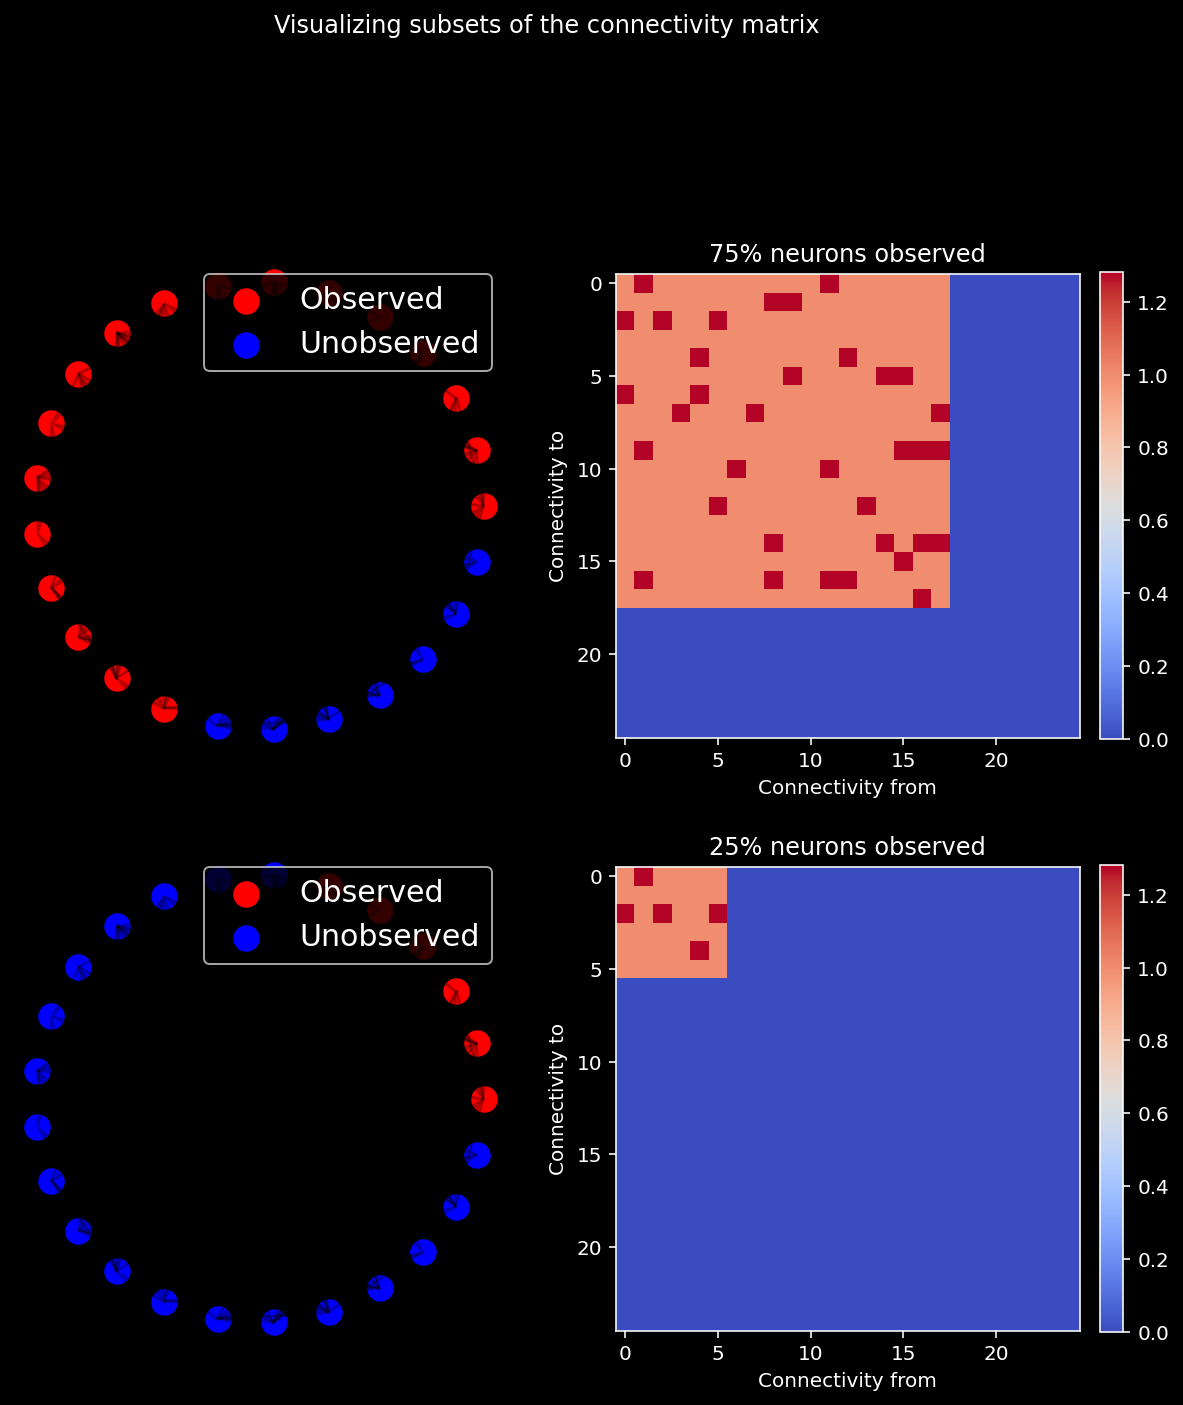

In [21]:
n_neurons = 25
A = create_connectivity(n_neurons)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
ratio_observed = [0.75, 0.25]  # the proportion of neurons observed in our system

for i, ratio in enumerate(ratio_observed):
    sel_idx = int(n_neurons * ratio)

    offset = np.zeros((n_neurons, n_neurons))
    axs[i,1].title.set_text("{}% neurons observed".format(int(ratio * 100)))
    offset[:sel_idx, :sel_idx] =  1 + A[:sel_idx, :sel_idx]
    im = axs[i, 1].imshow(offset, cmap="coolwarm", vmin=0, vmax=A.max() + 1)
    axs[i, 1].set_xlabel("Connectivity from")
    axs[i, 1].set_ylabel("Connectivity to")
    plt.colorbar(im, ax=axs[i, 1], fraction=0.046, pad=0.04)
    see_neurons(A,axs[i, 0],ratio)

plt.suptitle("Visualizing subsets of the connectivity matrix", y = 1.05)
plt.show()

We will first change the number of observed neurons in the network and inspect the resulting estimates of connectivity in this interactive demo. How does the estimated connectivity differ?

In [22]:
n_neurons = 50
A = create_connectivity(n_neurons, random_state=42)
X = simulate_neurons(A, 4000, random_state=42)

reg_args = {
    "fit_intercept": False,
    "alpha": 0.001
}

@widgets.interact
def plot_observed(n_observed=(5, 45, 5)):
  to_neuron = 0
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  sel_idx = n_observed
  ratio = (n_observed) / n_neurons
  offset = np.zeros((n_neurons, n_neurons))
  axs[0].title.set_text("{}% neurons observed".format(int(ratio * 100)))
  offset[:sel_idx, :sel_idx] =  1 + A[:sel_idx, :sel_idx]
  im = axs[1].imshow(offset, cmap="coolwarm", vmin=0, vmax=A.max() + 1)
  plt.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)

  see_neurons(A,axs[0], ratio, False)
  corr, R =  get_regression_corr_full_connectivity(n_neurons,
                                  A,
                                  X,
                                  ratio,
                                  reg_args)

  big_R = np.zeros(A.shape)
  big_R[:sel_idx, :sel_idx] =  1 + R
  im = axs[2].imshow(big_R, cmap="coolwarm", vmin=0, vmax=A.max() + 1)
  plt.colorbar(im, ax=axs[2],fraction=0.046, pad=0.04)
  c = 'w' if n_observed<(n_neurons-3) else 'k'
  axs[2].text(0,n_observed+3,"Correlation : {:.2f}".format(corr), color=c, size=15)
  axs[1].title.set_text("True connectivity")
  axs[1].set_xlabel("Connectivity from")
  axs[1].set_ylabel("Connectivity to")

  axs[2].title.set_text("Estimated connectivity")
  axs[2].set_xlabel("Connectivity from")

interactive(children=(IntSlider(value=25, description='n_observed', max=45, min=5, step=5), Output()), _dom_cl…

Let's inspect a plot of the correlation between true and estimated connectivity matrices vs the percent of neurons observed over multiple trials. What is the relationship that you see between performance and the number of neurons observed?

simulating trial 1 of 3
simulating trial 2 of 3
simulating trial 3 of 3


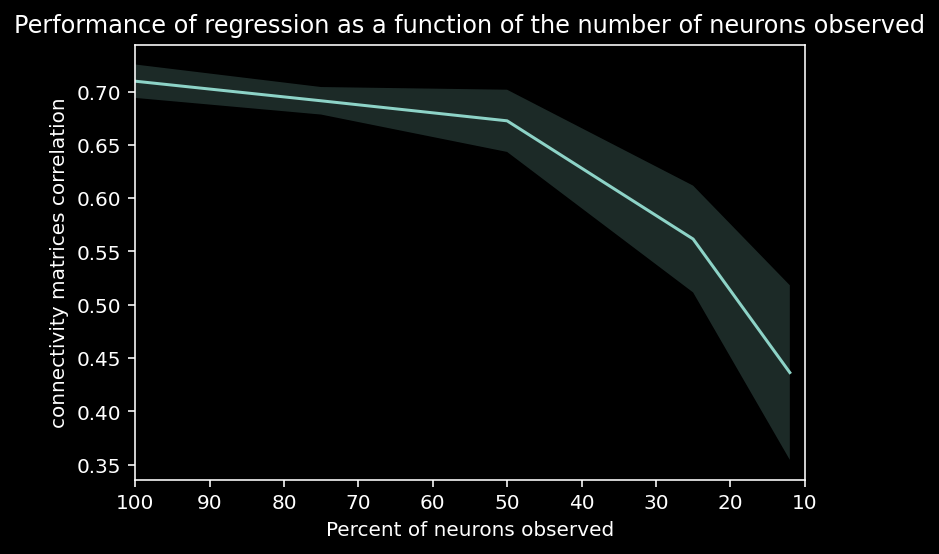

In [23]:
import warnings
warnings.filterwarnings('ignore')

# we'll simulate many systems for various ratios of observed neurons
n_neurons = 50
timesteps = 5000
ratio_observed = [1, 0.75, 0.5, .25, .12]  # the proportion of neurons observed in our system
n_trials = 3  # run it this many times to get variability in our results

reg_args = {
    "fit_intercept": False,
    "alpha": 0.001
}

corr_data = np.zeros((n_trials, len(ratio_observed)))
for trial in range(n_trials):

  A = create_connectivity(n_neurons, random_state=trial)
  X = simulate_neurons(A, timesteps)
  print("simulating trial {} of {}".format(trial + 1, n_trials))


  for j, ratio in enumerate(ratio_observed):
      result,_ = get_regression_corr_full_connectivity(n_neurons,
                                    A,
                                    X,
                                    ratio,
                                    reg_args)
      corr_data[trial, j] = result

corr_mean = np.nanmean(corr_data, axis=0)
corr_std = np.nanstd(corr_data, axis=0)

plt.plot(np.asarray(ratio_observed) * 100, corr_mean)
plt.fill_between(np.asarray(ratio_observed) * 100,
                    corr_mean - corr_std,
                    corr_mean + corr_std,
                    alpha=.2)
plt.xlim([100, 10])
plt.xlabel("Percent of neurons observed")
plt.ylabel("connectivity matrices correlation")
plt.title("Performance of regression as a function of the number of neurons observed");

#### Reminder
* in the brain we only observe a VERY small portion of neurons / voxels
* the above approach is similar to "dynamic causal modeling (DCM)"

**Take-home message**: putting *causal* in the name does NOT make it causal...

### Using instrumental variables to get at causality
If there is randomness naturally occurring in the system *that we can observe*, this in effect becomes the perturbations we can use to recover causal effects. This is called an **instrumental variable**. At high level, an instrumental variable must


1.   be observable
2.   affect a covariate you care about
3.   **not** effect the outcome, except through the covariate


It's rare to find these things in the wild, but when you do it's very powerful. 

### Non-neuro IV example
There is a negative correlation between X and Y, e.g. imagine
- $Z_{\text{taxes}}$: our tobacco tax **instrument**, which only affects an individual's tendency to smoke while pregnant within our system
- $X_{\text{smoking}}$: number of cigarettes smoked per day while pregnant, our "treatment" if this were a randomized trial
- $U_{\text{SES}}$: socioeconomic status (higher means weathier), a **confounder** if it is not observed
- $Y_{\text{birthweight}}$: child birthweight in grams, our outcome of interest

<img style="float:center; width:800px;" src="stuff/IV.png">

Let's suppose we have the following function for our system:

$Y_{\text{birthweight}} = 3000 + C_{\text{SES}} - 2T_{\text{smoking}},$

with the additional fact that $C_{\text{SES}}$ is negatively correlated with $T_{\text{smoking}}$. 

The causal effect we wish to estimate is the coefficient $-2$ for $T_{\text{smoking}}$, which means that if a mother smokes one additional cigarette per day while pregnant her baby will be 2 grams lighter at birth.

So let's look at the correlations between our variables.

In [24]:
def print_corr(v1, v2, corrs, idx_dict):
    """Helper function for formatting print statements for correlations"""
    text_dict = {'Z':'taxes', 'T':'# cigarettes', 'C':'SES status', 'Y':'birth weight'}
    print("Correlation between {} and {} ({} and {}): {:.3f}".format(v1, v2, text_dict[v1], text_dict[v2], corrs[idx_dict[v1], idx_dict[v2]]))


In [25]:
idx_dict = {
    'Z': 0,
    'T': 1,
    'C': 2,
    'Y': 3
}
# vars:             Z    T    C
covar = np.array([[1.0, 0.5, 0.0],  # Z
                  [0.5, 1.0, -0.5],  # T
                  [0.0, -0.5, 1.0]])  # C
# vars:  Z  T  C
means = [0, 5, 2]

# generate some data
np.random.seed(42)
data = np.random.multivariate_normal(mean=means, cov=2 * covar, size=2000)

# generate Y from our equation above
Y = 3000 + data[:, idx_dict['C']] - (2 * (data[:, idx_dict['T']]))

data = np.concatenate([data, Y.reshape(-1, 1)], axis=1)

Z = data[:, [idx_dict['Z']]]
T = data[:, [idx_dict['T']]]
C = data[:, [idx_dict['C']]]
Y = data[:, [idx_dict['Y']]]

corrs = np.corrcoef(data.transpose())

print_corr('C', 'T', corrs, idx_dict)
print_corr('C', 'Y', corrs, idx_dict)

Correlation between C and T (SES status and # cigarettes): -0.483
Correlation between C and Y (SES status and birth weight): 0.740


We see what is exactly represented in our graph above: 
* $C_{\text{SES}}$ is correlated with both $T_{\text{smoking}}$ and $Y_{\text{birthweight}}$
* thus $C_{\text{SES}}$ is a potential confounder if not included in our analysis

Let's say that it is difficult to observe and quantify $C_{\text{SES}}$, so we do not have it available to regress against. This is another example of the **omitted variable bias** we saw above.

What about $Z_{\text{taxes}}$? Does it satisfy conditions 1, 2, and 3 of an instrument?

In [26]:
print("Condition 2?")
print_corr('Z', 'T', corrs, idx_dict)
print("Condition 3?")
print_corr('Z', 'C', corrs, idx_dict)

Condition 2?
Correlation between Z and T (taxes and # cigarettes): 0.519
Condition 3?
Correlation between Z and C (taxes and SES status): 0.009


Perfect! We see that $Z_{\text{taxes}}$ is correlated with $T_{\text{smoking}}$ (#2) but is uncorrelated with $C_{\text{SES}}$ (#3).  $Z_\text{taxes}$ is also observable (#1), so we've satisfied our three criteria for an instrument:

1.   $Z_\text{taxes}$ is observable
2.   $Z_\text{taxes}$ affects $T_{\text{smoking}}$
3.   $Z_\text{taxes}$ doesn't affect $Y_{\text{birthweight}}$ except through $T_{\text{smoking}}$ (ie $Z_\text{taxes}$ doesn't affect or is affected by $C_\text{SES}$)

### How does IV work practically?
The easiest way to imagine IV is that the instrument is **an observable source of "randomness"** that affects the treatment. In this way it's similar to the interventions we talked about earlier (randomized controlled trials).

But how do you actually use the instrument? The key is that we need to extract **the component of the treatment that is due only to the effect of the instrument**. We will call this component $\hat{T}$.
$$
\hat{T}\leftarrow \text{The unconfounded component of }T
$$
Getting $\hat{T}$ is fairly simple. It is simply the predicted value of $T$ found in a regression that has only the instrument $Z$ as input.

Once we have the unconfounded component in hand, getting the causal effect is as easy as regressing the outcome on $\hat{T}$.

#### IV estimation using two-stage least squares

The fundamental technique for instrumental variable estimation is **two-stage least squares**. 

We run two regressions:

1. The first stage gets  $\hat{T}_{\text{smoking}}$ by regressing $T_{\text{smoking}}$ on $Z_\text{taxes}$, fitting the parameter $\hat{\alpha}$:

$$
\hat{T}_{\text{smoking}} = \hat{\alpha} Z_\text{taxes}
$$

2. The second stage then regresses $Y_{\text{birthweight}}$ on $\hat{T}_{\text{smoking}}$ to obtain an estimate $\hat{\beta}$ of the causal effect:

$$
\hat{Y}_{\text{birthweight}} = \hat{\beta} \hat{T}_{\text{smoking}} 
$$

The first stage estimates the **unconfounded component** of $T_{\text{smoking}}$ (ie, unaffected by the confounder $C_{\text{SES}}$), as we discussed above. 

Then, the second stage uses this unconfounded component $\hat{T}_{\text{smoking}}$ to estimate the effect of smoking on $\hat{Y}_{\text{birthweight}}$. 

Let's run the regression of $T_{\text{smoking}}$ on $Z_\text{taxes}$ to compute $\hat{T}_{\text{smoking}}$. We will then check whether our estimate is still confounded with $C_{\text{SES}}$ by comparing the correlation of $C_{\text{SES}}$  with $T_{\text{smoking}}$ vs $\hat{T}_{\text{smoking}}$.

In [27]:
from sklearn.linear_model import LinearRegression, Lasso

def fit_first_stage(T, Z):
    """
    Estimates T_hat as the first stage of a two-stage least squares.
    Args:
        T (np.ndarray): our observed, possibly confounded, treatment of shape (n, 1)
        Z (np.ndarray): our observed instruments of shape (n, 1)
    Returns
        T_hat (np.ndarray): our estimate of the unconfounded portion of T
    """

    # Initialize linear regression model
    stage1 = LinearRegression(fit_intercept=True)

    # Fit linear regression model
    stage1.fit(Z, T)

    # Predict T_hat using linear regression model
    T_hat = stage1.predict(Z)

    return T_hat

T_hat = fit_first_stage(T, Z)

T_C_corr = np.corrcoef(T.transpose(), C.transpose())[0, 1]
T_hat_C_corr = np.corrcoef(T_hat.transpose(), C.transpose())[0, 1]
print("Correlation between T and C: {:.3f}".format(T_C_corr))
print("Correlation between T_hat and C: {:.3f}".format(T_hat_C_corr))

Correlation between T and C: -0.483
Correlation between T_hat and C: 0.009


Now let's implement the second stage! 

In [28]:
def fit_second_stage(T_hat, Y):
    """
    Estimates a scalar causal effect from 2-stage least squares regression using
    an instrument.
    Args:
        T_hat (np.ndarray): the output of the first stage regression
        Y (np.ndarray): our observed response (n, 1)
    Returns:
        beta (float): the estimated causal effect
    """
    # Initialize linear regression model
    stage2 = LinearRegression(fit_intercept=True)

    # Fit model to data
    stage2.fit(T_hat, Y)

    return stage2.coef_

T_hat = fit_first_stage(T, Z)
beta = fit_second_stage(T_hat, Y)
print("Estimated causal effect is: {:.3f}".format(beta[0, 0]))

Estimated causal effect is: -1.984


This is quite close to the true causal effect of −2!

### applying IVs to neural systems

Now, say we have the neural system we have been simulating, except with an additional variable $\vec{z}$. This will be our instrumental variable. 

We treat $\vec{z}$ as a source of noise in the dynamics of our neurons:

$$
\vec{x}_{t+1} = \sigma(A\vec{x}_t + \eta \vec{z}_{t+1} + \epsilon_t)
$$

- $\eta$ is what we'll call the "strength" of our IV
- $\vec{z}_t$ is a random binary variable, $\vec{z}_t \sim Bernoulli(0.5)$

Remember that for each neuron $i$, we are trying to figure out whether $i$ is connected to (causally affects) the other neurons in our system *at the next time step*. So for timestep $t$, we want to determine whether $\vec{x}_{i,t}$ affects all the other neurons at $\vec{x}_{t+1}$. For a given neuron $i$, $\vec{z}_{i,t}$ satistfies the 3 criteria for a valid instrument. 


**What could $z$ be, biologically?**

Imagine $z$ to be some injected current through an *in vivo* patch clamp. It affects each neuron individually, and only affects dynamics through that neuron.

The cool thing about IV is that you don't have to control $z$ yourself - it can be observed. So if you mess up your wiring and accidentally connect the injected voltage to an AM radio, no worries. As long as you can observe the signal the method will work.

So let's modify the function that simulates the neural system, but this time make the update rule include the effect of the instrumental variable $z$.

In [29]:
def plot_neural_activity(X):
  """Plot first 10 timesteps of neural activity

  Args:
    X (ndarray): neural activity (n_neurons by timesteps)

  """
  f, ax = plt.subplots()
  im = ax.imshow(X[:, :10], aspect='auto')
  divider = make_axes_locatable(ax)
  cax1 = divider.append_axes("right", size="5%", pad=0.15)
  plt.colorbar(im, cax=cax1)
  ax.set(xlabel='Timestep', ylabel='Neuron', title='Simulated Neural Activity')


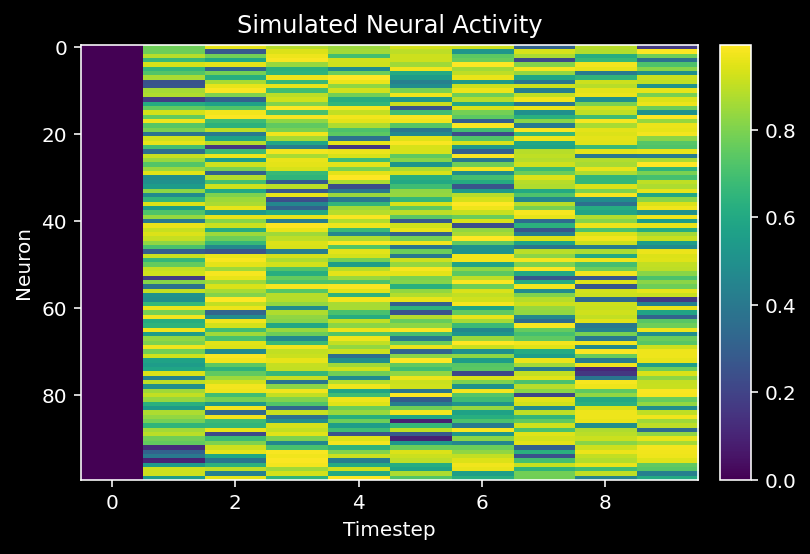

In [30]:
def simulate_neurons_iv(n_neurons, timesteps, eta, random_state=42):
    """
    Simulates a dynamical system for the specified number of neurons and timesteps.
    Args:
        n_neurons (int): the number of neurons in our system.
        timesteps (int): the number of timesteps to simulate our system.
        eta (float): the strength of the instrument
        random_state (int): seed for reproducibility
    Returns:
        The tuple (A,X,Z) of the connectivity matrix, simulated system, and instruments.
        - A has shape (n_neurons, n_neurons)
        - X has shape (n_neurons, timesteps)
        - Z has shape (n_neurons, timesteps)
    """
    np.random.seed(random_state)
    A = create_connectivity(n_neurons, random_state)

    X = np.zeros((n_neurons, timesteps))
    Z = np.random.choice([0, 1], size=(n_neurons, timesteps))
    for t in range(timesteps - 1):

      IV_on_this_timestep = (eta * Z[:, t + 1])

      X[:, t + 1] = sigmoid(A.dot(X[:, t]) + IV_on_this_timestep + np.random.multivariate_normal(np.zeros(n_neurons), np.eye(n_neurons)))

    return A, X, Z

# Parameters
timesteps = 5000  # Simulate for 5000 timesteps.
n_neurons = 100  # the size of our system
eta = 2  # the strength of our instrument, higher is stronger


# Uncomment below to test your function

# Simulate our dynamical system for the given amount of time
A, X, Z = simulate_neurons_iv(n_neurons, timesteps, eta)
plot_neural_activity(X)

Now we can run the network implementation of the above 2-stage least squares procedure...

In [31]:
def get_iv_estimate_network(X, Z):
    """
    Estimates the connectivity matrix from 2-stage least squares regression
    using an instrument.

    Args:
        X (np.ndarray): our simulated system of shape (n_neurons, timesteps)
        Z (np.ndarray): our observed instruments of shape (n_neurons, timesteps)

    Returns:

        V (np.ndarray): the estimated connectivity matrix
    """
    n_neurons = X.shape[0]
    Y = X[:, 1:].transpose()

    # apply inverse sigmoid transformation
    Y = logit(Y)

    # Stage 1: regress X on Z
    stage1 = MultiOutputRegressor(LinearRegression(fit_intercept=True), n_jobs=-1)
    stage1.fit(Z[:, :-1].transpose(), X[:, :-1].transpose())
    X_hat = stage1.predict(Z[:, :-1].transpose())

    # Stage 2: regress Y on X_hatI
    stage2 = MultiOutputRegressor(LinearRegression(fit_intercept=True), n_jobs=-1)
    stage2.fit(X_hat, Y)

    # Get estimated effects
    V = np.zeros((n_neurons, n_neurons))
    for i, estimator in enumerate(stage2.estimators_):
        V[i, :] = estimator.coef_

    return V

Let's visualize if this worked?

IV estimated correlation: 0.916


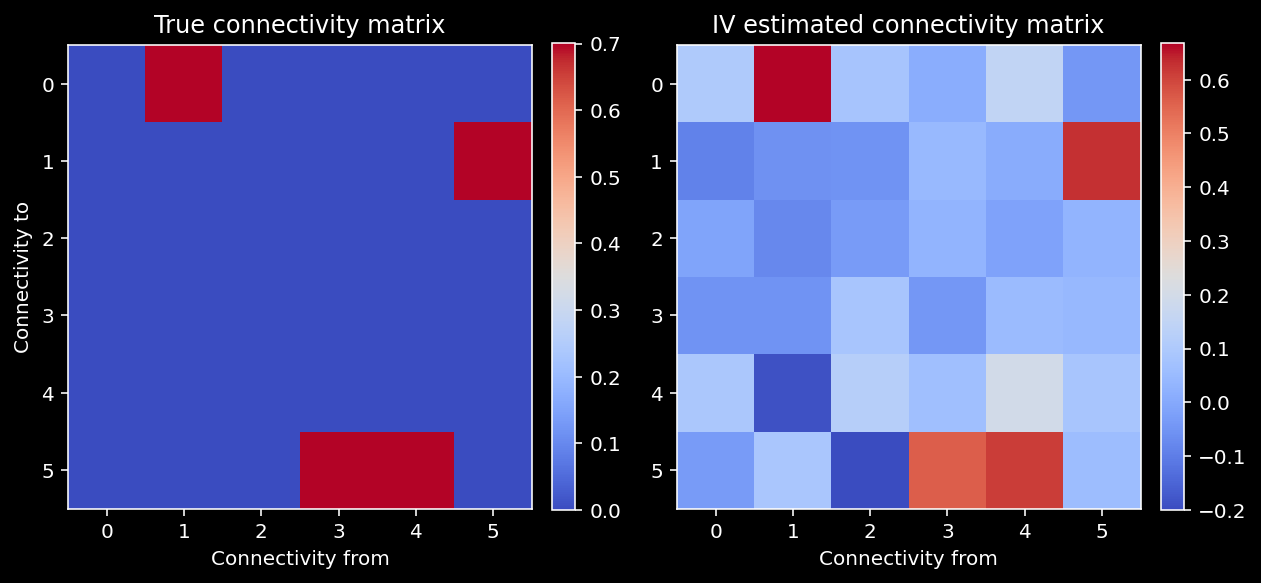

In [32]:
n_neurons = 6
timesteps = 10000
random_state = 42
eta = 2

A, X, Z = simulate_neurons_iv(n_neurons, timesteps, eta, random_state)
V = get_iv_estimate_network(X, Z)
print("IV estimated correlation: {:.3f}".format(np.corrcoef(A.flatten(), V.flatten())[1, 0]))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

im = axs[0].imshow(A, cmap="coolwarm")
fig.colorbar(im, ax=axs[0],fraction=0.046, pad=0.04)
axs[0].title.set_text("True connectivity matrix")
axs[0].set(xlabel='Connectivity from', ylabel='Connectivity to')

im = axs[1].imshow(V, cmap="coolwarm")
fig.colorbar(im, ax=axs[1],fraction=0.046, pad=0.04)
axs[1].title.set_text("IV estimated connectivity matrix")
axs[1].set(xlabel='Connectivity from')

plt.show()

The IV estimates seem to perform pretty well! 

### IVs and omitted variable bias
What if we tried estimating connectivity with IV vs regression on a subset of observed neurons?

Which method does better with fewer observed neurons?

In [33]:
n_neurons = 30
timesteps = 20000
random_state = 42
eta = 2
A, X, Z = simulate_neurons_iv(n_neurons, timesteps, eta, random_state)


reg_args = {
    "fit_intercept": False,
    "alpha": 0.001
}

def get_regression_estimate_full_connectivity(X):
    """
    Estimates the connectivity matrix using lasso regression.

    Args:
        X (np.ndarray): our simulated system of shape (n_neurons, timesteps)
        neuron_idx (int): optionally provide a neuron idx to compute connectivity for
    Returns:
        V (np.ndarray): estimated connectivity matrix of shape (n_neurons, n_neurons).
                        if neuron_idx is specified, V is of shape (n_neurons,).
    """
    n_neurons = X.shape[0]

    # Extract Y and W as defined above
    W = X[:, :-1].transpose()
    Y = X[:, 1:].transpose()

    # apply inverse sigmoid transformation
    Y = logit(Y)

    # fit multioutput regression
    reg = MultiOutputRegressor(Lasso(fit_intercept=False, alpha=0.01, max_iter=200), n_jobs=-1)
    reg.fit(W, Y)

    V = np.zeros((n_neurons, n_neurons))
    for i, estimator in enumerate(reg.estimators_):
        V[i, :] = estimator.coef_

    return V


def get_regression_corr_full_connectivity(n_neurons, A, X, observed_ratio, regression_args):
    """
    A wrapper function for our correlation calculations between A and the V estimated
    from regression.

    Args:
        n_neurons (int): number of neurons
        A (np.ndarray): connectivity matrix
        X (np.ndarray): dynamical system
        observed_ratio (float): the proportion of n_neurons observed, must be betweem 0 and 1.
        regression_args (dict): dictionary of lasso regression arguments and hyperparameters

    Returns:
        A single float correlation value representing the similarity between A and R
    """
    assert (observed_ratio > 0) and (observed_ratio <= 1)

    sel_idx = np.clip(int(n_neurons*observed_ratio), 1, n_neurons)

    sel_X = X[:sel_idx, :]
    sel_A = A[:sel_idx, :sel_idx]

    sel_V = get_regression_estimate_full_connectivity(sel_X)
    return np.corrcoef(sel_A.flatten(), sel_V.flatten())[1,0], sel_V


@widgets.interact
def plot_observed(ratio=[0.2, 0.4, 0.6, 0.8, 1.0]):
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  sel_idx = int(ratio * n_neurons)
  n_observed = sel_idx
  offset = np.zeros((n_neurons, n_neurons))
  offset[:sel_idx, :sel_idx] =  1 + A[:sel_idx, :sel_idx]
  im = axs[0].imshow(offset, cmap="coolwarm", vmin=0, vmax=A.max() + 1)
  axs[0].title.set_text("True connectivity")
  axs[0].set_xlabel("Connectivity to")
  axs[0].set_ylabel("Connectivity from")
  plt.colorbar(im, ax=axs[0],fraction=0.046, pad=0.04)

  sel_A = A[:sel_idx, :sel_idx]
  sel_X = X[:sel_idx, :]
  sel_Z = Z[:sel_idx, :]

  V = get_iv_estimate_network(sel_X, sel_Z)
  iv_corr = np.corrcoef(sel_A.flatten(), V.flatten())[1, 0]

  big_V = np.zeros(A.shape)
  big_V[:sel_idx, :sel_idx] =  1 + V

  im = axs[1].imshow(big_V, cmap="coolwarm", vmin=0, vmax=A.max() + 1)
  plt.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)
  c = 'w' if n_observed < (n_neurons - 3) else 'k'
  axs[1].text(0,n_observed + 2, "Correlation : {:.2f}".format(iv_corr), color=c, size=15)
  axs[1].axis("off")


  reg_corr, R = get_regression_corr_full_connectivity(n_neurons,
                                  A,
                                  X,
                                  ratio,
                                  reg_args)


  big_R = np.zeros(A.shape)
  big_R[:sel_idx, :sel_idx] =  1 + R

  im = axs[2].imshow(big_R, cmap="coolwarm", vmin=0, vmax=A.max() + 1)
  plt.colorbar(im, ax=axs[2], fraction=0.046, pad=0.04)
  c = 'w' if n_observed<(n_neurons-3) else 'k'
  axs[1].title.set_text("Estimated connectivity (IV)")
  axs[1].set_xlabel("Connectivity to")
  axs[1].set_ylabel("Connectivity from")

  axs[2].text(0, n_observed + 2,"Correlation : {:.2f}".format(reg_corr), color=c, size=15)
  axs[2].axis("off")
  axs[2].title.set_text("Estimated connectivity (regression)")
  axs[2].set_xlabel("Connectivity to")
  axs[2].set_ylabel("Connectivity from")

interactive(children=(Dropdown(description='ratio', options=(0.2, 0.4, 0.6, 0.8, 1.0), value=0.2), Output()), …

We can also visualize the performance of regression and IV as a function of the observed neuron ratio below.

In [34]:
def compare_iv_estimate_to_regression(observed_ratio):
  """
  A wrapper function to compare IV and Regressor performance as a function of observed neurons

  Args:
        observed_ratio(list): a list of different observed ratios (out of the whole system)
  """

  #Let's compare IV estimates to our regression estimates, uncomment the code below

  reg_corrs = np.zeros((len(observed_ratio),))
  iv_corrs = np.zeros((len(observed_ratio),))
  for j, ratio in enumerate(observed_ratio):
      print(ratio)
      sel_idx = int(ratio * n_neurons)

      sel_X = X[:sel_idx, :]
      sel_Z = X[:sel_idx, :]
      sel_A = A[:sel_idx, :sel_idx]

      sel_reg_V = get_regression_estimate(sel_X)
      reg_corrs[j] = np.corrcoef(sel_A.flatten(), sel_reg_V.flatten())[1, 0]

      sel_iv_V = get_iv_estimate_network(sel_X, sel_Z)
      iv_corrs[j] = np.corrcoef(sel_A.flatten(), sel_iv_V.flatten())[1, 0]

  # Plotting IV vs lasso performance
  plt.plot(observed_ratio, reg_corrs)
  plt.plot(observed_ratio, iv_corrs)
  plt.xlim([1, 0.2])
  plt.ylabel("Connectivity matrices correlation with truth")
  plt.xlabel("Fraction of observed variables")
  plt.title("IV and lasso performance as a function of observed neuron ratio")
  plt.legend(['Regression', 'IV'])


def get_regression_estimate(X, neuron_idx=None):
    """
    Estimates the connectivity matrix using lasso regression.

    Args:
        X (np.ndarray): our simulated system of shape (n_neurons, timesteps)
        neuron_idx (int): optionally provide a neuron idx to compute connectivity for
    Returns:
        V (np.ndarray): estimated connectivity matrix of shape (n_neurons, n_neurons).
                        if neuron_idx is specified, V is of shape (n_neurons,).
    """
    n_neurons = X.shape[0]

    # Extract Y and W as defined above
    W = X[:, :-1].transpose()
    if neuron_idx is None:
        Y = X[:, 1:].transpose()
    else:
        Y = X[[neuron_idx], 1:].transpose()

    # apply inverse sigmoid transformation
    Y = logit(Y)

    # fit multioutput regression
    regression = MultiOutputRegressor(Lasso(fit_intercept=False, alpha=0.01), n_jobs=-1)

    regression.fit(W,Y)

    if neuron_idx is None:
        V = np.zeros((n_neurons, n_neurons))
        for i, estimator in enumerate(regression.estimators_):
            V[i, :] = estimator.coef_
    else:
        V = regression.estimators_[0].coef_

    return V


1
0.8
0.6
0.4
0.2


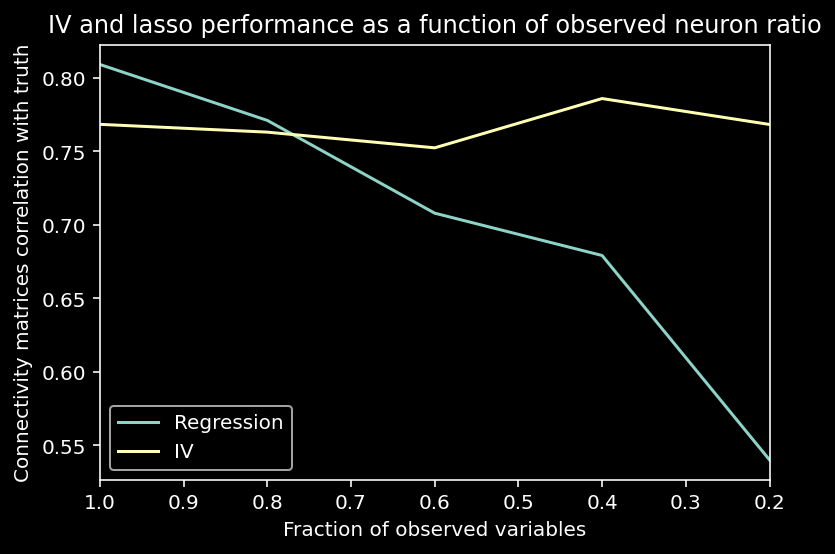

In [35]:
n_neurons = 40  # the size of the system
timesteps = 20000
random_state = 42
eta = 2  # the strength of our instrument

A, X, Z = simulate_neurons_iv(n_neurons, timesteps, eta, random_state)

observed_ratio = [1, 0.8, 0.6, 0.4, 0.2]

compare_iv_estimate_to_regression(observed_ratio)

We see that IVs handle omitted variable bias (when the instrument is strong and we have enough data).

#### The costs of IV analysis

* we need to find an appropriate and valid instrument
* because of the 2-stage estimation process, we need strong instruments or else our standard errors will be large



### The influence of instrument strength on IV performance
Let's explore how the strength of the instrument $\eta$ affects the quality of estimates with instrumental variables. 

In [36]:
def plot_performance_vs_eta(etas, corr_data):
  """ Plot IV estimation performance as a function of instrument strength

    Args:
      etas (list): list of instrument strengths
      corr_data (ndarray): n_trials x len(etas) array where each element is the correlation
        between true and estimated connectivity matries for that trial and
        instrument strength

  """
  corr_mean = corr_data.mean(axis=0)
  corr_std = corr_data.std(axis=0)

  plt.plot(etas, corr_mean)
  plt.fill_between(etas,
              corr_mean - corr_std,
              corr_mean + corr_std,
              alpha=.2)
  plt.xlim([etas[0], etas[-1]])
  plt.title("IV performance as a function of instrument strength")
  plt.ylabel("Correlation b.t. IV and true connectivity")
  plt.xlabel("Strength of instrument (eta)")
  plt.show()

Trial 1 of 3
Trial 2 of 3
Trial 3 of 3


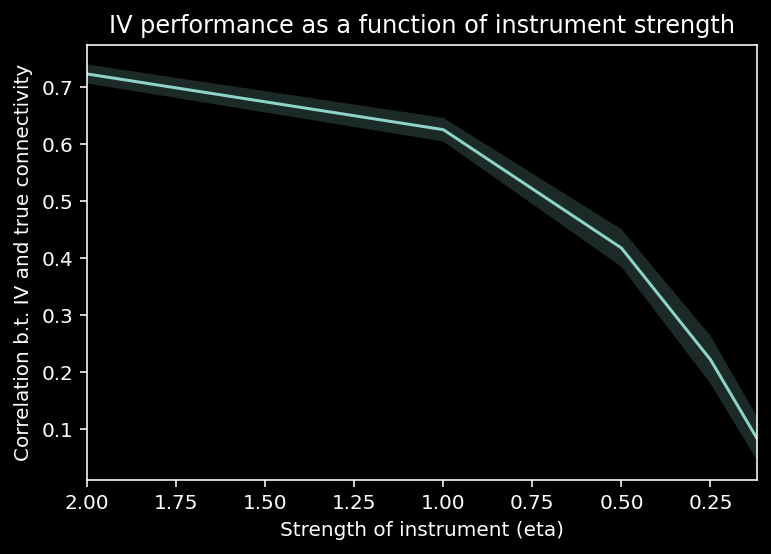

In [37]:
def instrument_strength_effect(etas, n_neurons, timesteps, n_trials):
  """ Compute IV estimation performance for different instrument strengths
  Args:
    etas (list): different instrument strengths to compare
    n_neurons (int): number of neurons in simulation
    timesteps (int): number of timesteps in simulation
    n_trials (int): number of trials to compute
  Returns:
    ndarray: n_trials x len(etas) array where each element is the correlation
        between true and estimated connectivity matries for that trial and
        instrument strength
  """

  # Initialize corr array
  corr_data = np.zeros((n_trials, len(etas)))

  # Loop over trials
  for trial in range(n_trials):
      print("Trial {} of {}".format(trial + 1, n_trials))

      # Loop over instrument strenghs
      for j, eta in enumerate(etas):

          # Simulate system
          A, X, Z = simulate_neurons_iv(n_neurons, timesteps, eta, trial)

          # Compute IV estimate
          iv_V = get_iv_estimate_network(X, Z)

          # Compute correlation
          corr_data[trial, j] =  np.corrcoef(A.flatten(), iv_V.flatten())[1, 0]

  return corr_data

# Parameters of system
n_neurons = 20
timesteps = 10000
n_trials = 3
etas = [2, 1, 0.5, 0.25, 0.12]  # instrument strengths to search over

corr_data = instrument_strength_effect(etas, n_neurons, timesteps, n_trials)
plot_performance_vs_eta(etas, corr_data)

### Granger causality
Another potential solution to temporal causation that we might consider: [*Granger Causality*](https://en.wikipedia.org/wiki/Granger_causality).

But, like the simultaneous fitting we explored in the GLM section, this method still fails in the presence of unobserved variables.

We are testing whether a time series $X$ Granger-causes a time series $Y$ through a hypothesis test:

- the null hypothesis $H_0$: lagged values of $X$ do not help predict values of $Y$ 

- the alternative hypothesis $H_a$: lagged values of $X$ **do** help predict values of $Y$ 

Mechanically, this is accomplished by fitting autoregressive models for $y_{t}$. We fail to reject the hypothesis if none of the $x_{t-k}$ terms are retained as significant in the regression. For simplicity, we will consider only one time lag. So, we have:

$$
H_0: y_t = a_0 + a_1 y_{t-1} +\epsilon_t
$$

$$
H_a: y_t = a_0 + a_1 y_{t-1} + b_1 x_{t-1} +\epsilon_t
$$

We will first evaluate Granger causality in a small system.

In [38]:
from statsmodels.tsa.stattools import grangercausalitytests

def compare_granger_connectivity(A, reject_null, selected_neuron):
  """Plot granger connectivity vs true

  Args:
    A (ndarray): true connectivity (n_neurons by n_neurons)
    reject_null (list): outcome of granger causality, length n_neurons
    selecte_neuron (int): the neuron we are plotting connectivity from

  """
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))

  im = axs[0].imshow(A[:, [selected_neuron]], cmap='coolwarm', aspect='auto')
  plt.colorbar(im, ax = axs[0])
  axs[0].set_xticks([0])
  axs[0].set_xticklabels([selected_neuron])
  axs[0].title.set_text("True connectivity for neuron {}".format(selected_neuron))

  im = axs[1].imshow(np.array([reject_null]).transpose(), cmap='coolwarm', aspect='auto')
  plt.colorbar(im, ax=axs[1])
  axs[1].set_xticks([0])
  axs[1].set_xticklabels([selected_neuron])
  axs[1].title.set_text("Granger causality connectivity for neuron {}".format(selected_neuron))


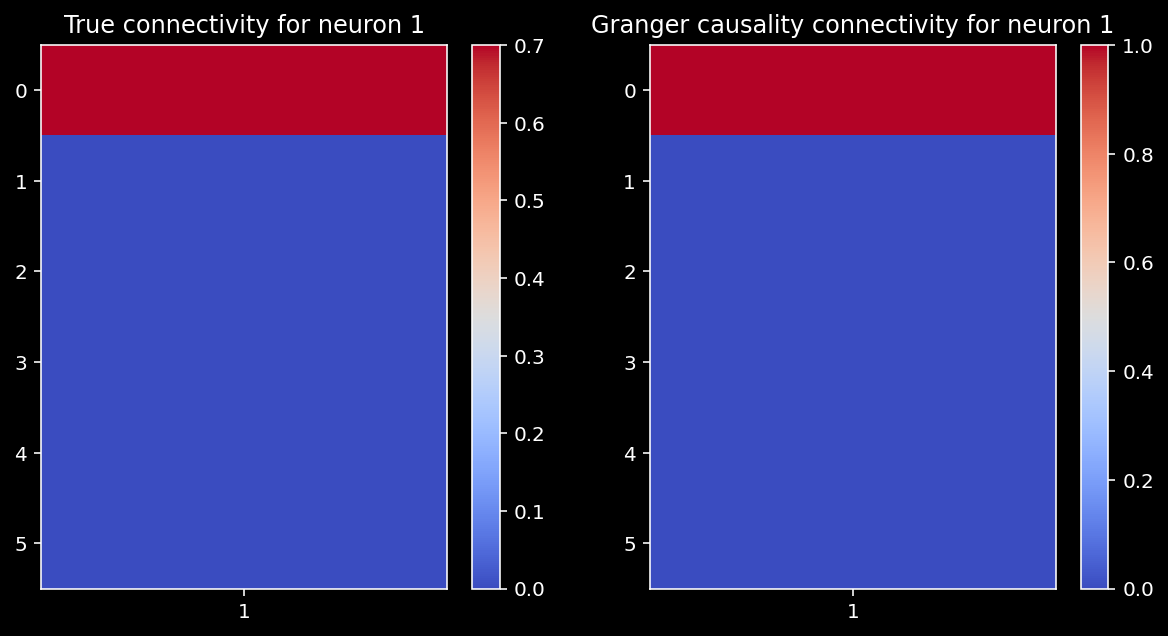

In [39]:
def get_granger_causality(X, selected_neuron, alpha=0.05):
    """
    Estimates the lag-1 granger causality of the given neuron on the other neurons in the system.
    Args:
        X (np.ndarray): the matrix holding our dynamical system of shape (n_neurons, timesteps)
        selected_neuron (int): the index of the neuron we want to estimate granger causality for
        alpha (float): Bonferroni multiple comparisons correction
    Returns:
        A tuple (reject_null, p_vals)
        reject_null (list): a binary list of length n_neurons whether the null was
            rejected for the selected neuron granger causing the other neurons
        p_vals (list): a list of the p-values for the corresponding Granger causality tests
    """
    n_neurons = X.shape[0]
    max_lag = 1

    reject_null = []
    p_vals = []

    for target_neuron in range(n_neurons):
        ts_data = X[[target_neuron, selected_neuron], :].transpose()

        res = grangercausalitytests(ts_data, maxlag=max_lag, verbose=False)

        # Gets the p-value for the log-ratio test
        pval = res[1][0]['lrtest'][1]

        p_vals.append(pval)
        reject_null.append(int(pval < alpha))

    return reject_null, p_vals


# Set up small system
n_neurons = 6
timesteps = 5000
random_state = 42
selected_neuron = 1

A = create_connectivity(n_neurons, random_state)
X = simulate_neurons(A, timesteps, random_state)

reject_null, p_vals = get_granger_causality(X, selected_neuron)
compare_granger_connectivity(A, reject_null, selected_neuron)

Looks good! Let's also check the correlation between Granger estimates and the true connectivity.

In [40]:
np.corrcoef(A[:,selected_neuron], np.array(reject_null))[1, 0]

1.0

When we have a small system, we correctly identify the causality of neuron 1.

### Granger causality in large systems
Let's run Granger causality on a large system with 100 neurons. Does it still work well? How does the number of timesteps matter?

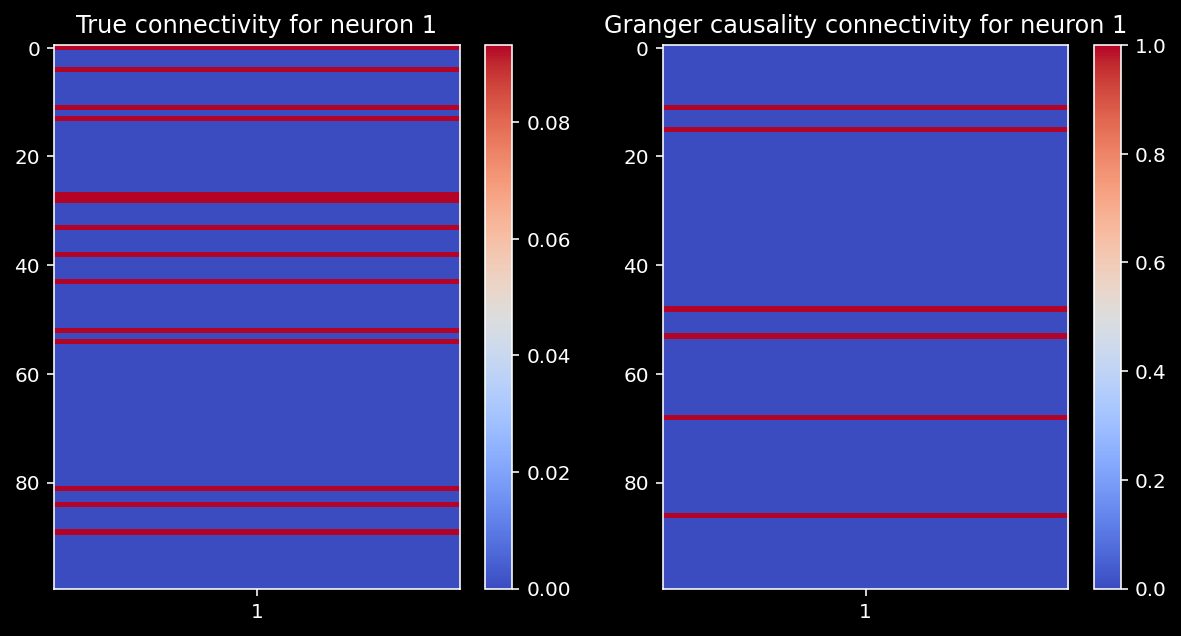

In [41]:
n_neurons = 100
timesteps = 5000
random_state = 42
selected_neuron = 1
A = create_connectivity(n_neurons, random_state)
X = simulate_neurons(A, timesteps, random_state)

# get granger causality estimates
reject_null, p_vals = get_granger_causality(X, selected_neuron)
compare_granger_connectivity(A, reject_null, selected_neuron)

Let's again check the correlation between the Granger estimates and the true connectivity. Are we able to recover the true connectivity well in this larger system?

In [42]:
np.corrcoef(A[:,selected_neuron], np.array(reject_null))[1, 0]

0.019416331902158156

#### Notes on Granger Causality

Here we considered bivariate Granger causality -- for each pair of neurons A,B, does one Granger-cause the other? You might wonder whether considering more variables will help with estimation?

* Conditional Granger Causality is a technique that allows for a multivariate system, where we test whether A Granger-causes B conditional on the other variables in the system.
* Even after controlling for variables in the system, conditional Granger causality will also perform poorly as our system gets larger. Plus, measuring the additional variables to condition on may be infeasible in practical applications, which would introduce omitted variable bias as we saw in the regression exercise.

One takeaway here is that as our estimation procedures become more sophisticated, they also become more difficult to interpret. We always need to understand the methods and the assumptions that are made.

### Further readings

* ["the book of why" (Pearl & Mackenzie, 2018)](http://bayes.cs.ucla.edu/WHY/)
* ["Causality" (Pearl, 2009)](http://bayes.cs.ucla.edu/BOOK-2K/)
* [more suggested readings from NMA...](https://mfr.ca-1.osf.io/render?url=https://osf.io/5kbrs/?direct%26mode=render%26action=download%26mode=render)